<a href="https://colab.research.google.com/github/eastmountaincode/portfolio/blob/main/Weather_and_Bike_Share_Ridership.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

What we will do in this notebook:

This notebook is prepared as a part of AI course.
The main idea is to walk through the process of data analysis in a systematic way.
We will follow a sequence starting with assessing data quality. We will then select features and build models using AutoMl with H2O. We will use SHAP plot in order to understand and interpret the resutls.

The sections are organized based on these steps.

We will adopt code from our professor, Dr. Nik Brown's, notebooks. They are accessible from his [GitHub](https://github.com/nikbearbrown).


## About the Data

This is a combined dataset of data from https://www.bluebikes.com/system-data and https://www.wunderground.com/. 

Weather data is pulled from six weather stations in the Greater Boston Area.

Weather data is daily average data for the day, things like temperature high, temperature low, average temperature, average pressure, etc.

Bike trip data is data for individual bike trips.


Bike trip data is associated with weather data by calculating the closest weather station (for the bikeshare station at the START of the trip) out of the 6 stations, and by the date of bike trip/weather data.

This data is for the month of November 2021.

**Research question**: Which weather factors have the biggest impact on bikeshare trip duration? What other factors affect trip duration?

Trip duration is in seconds.

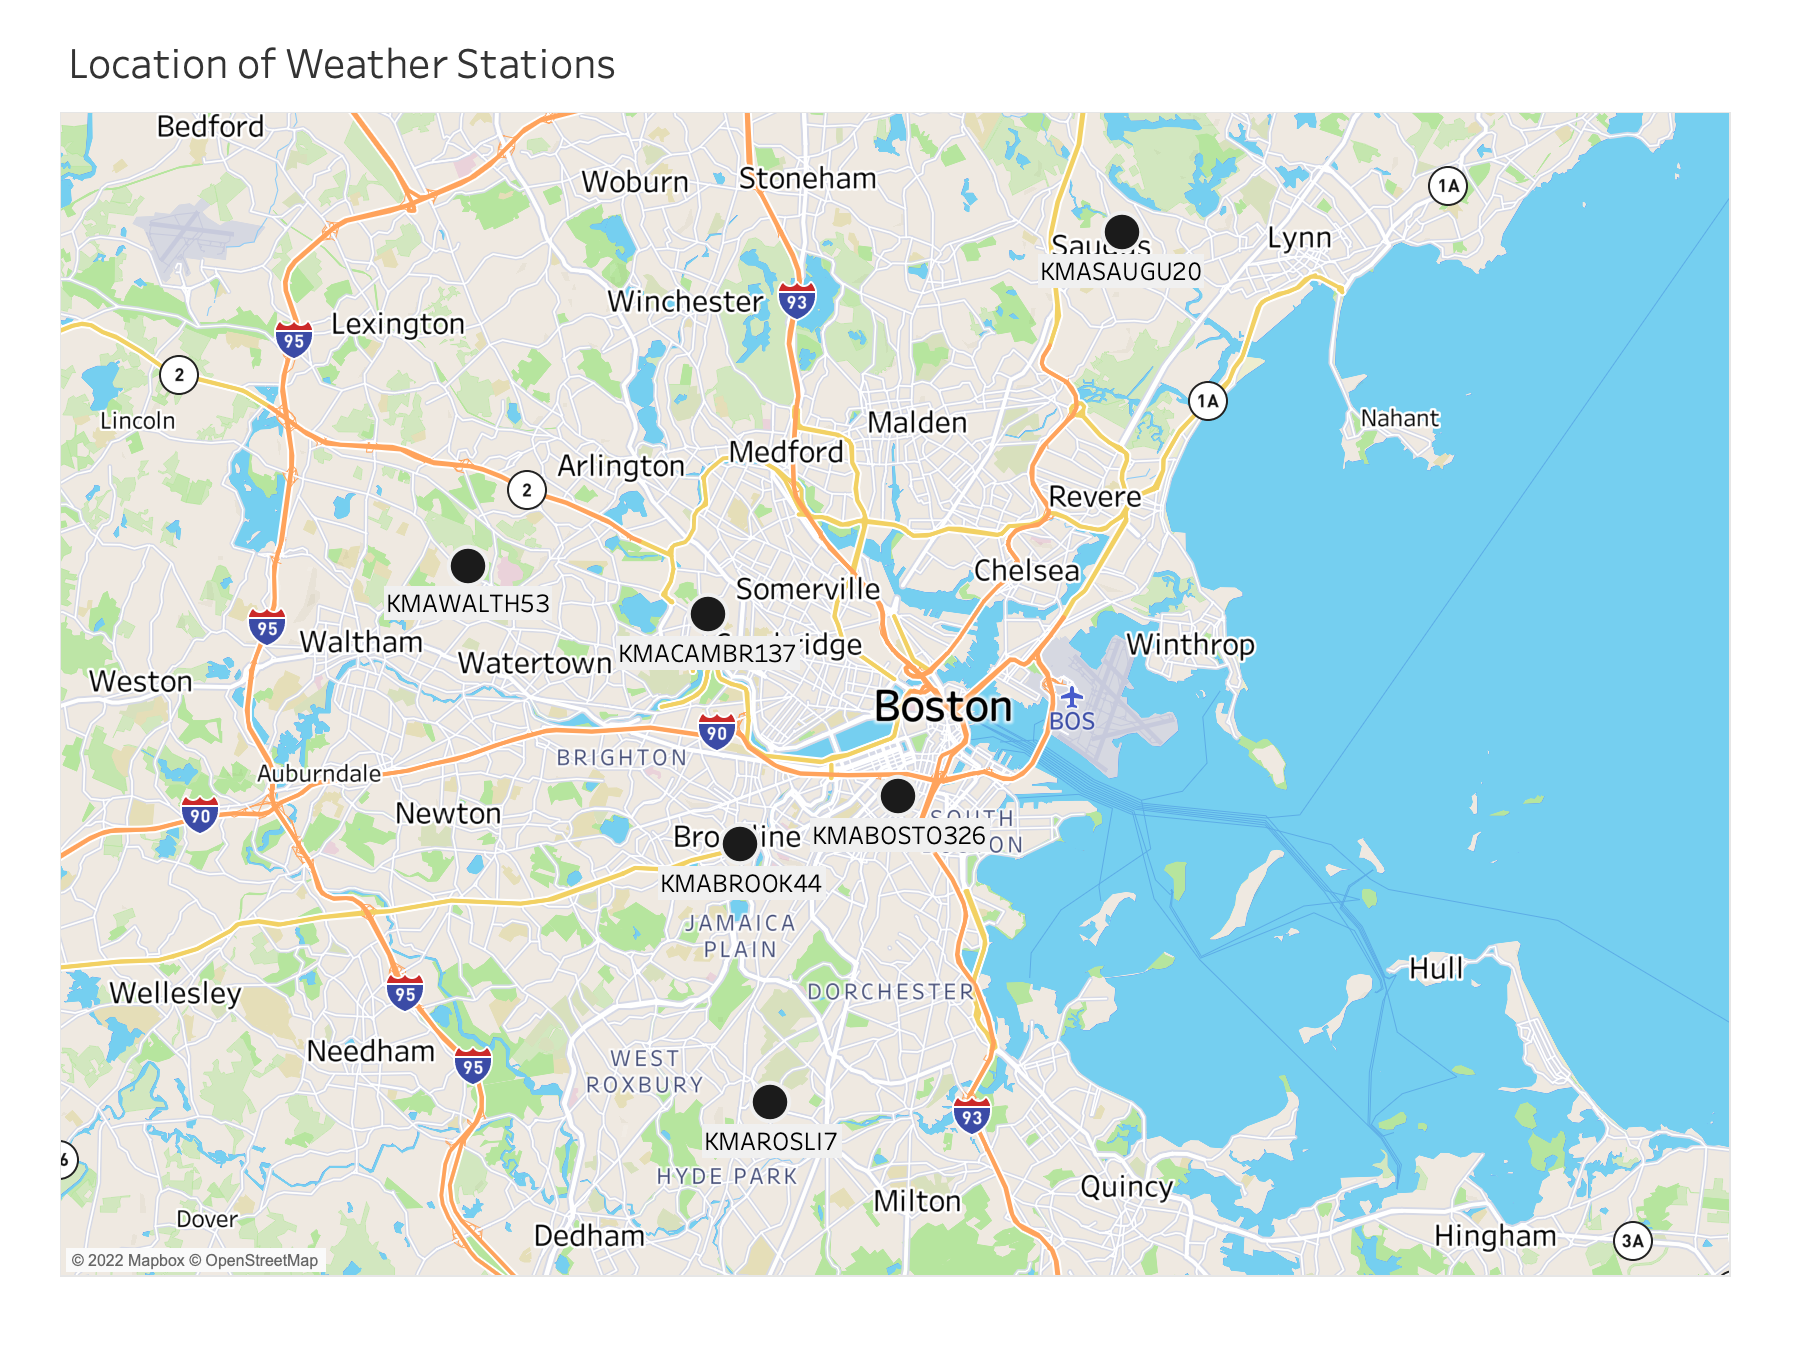

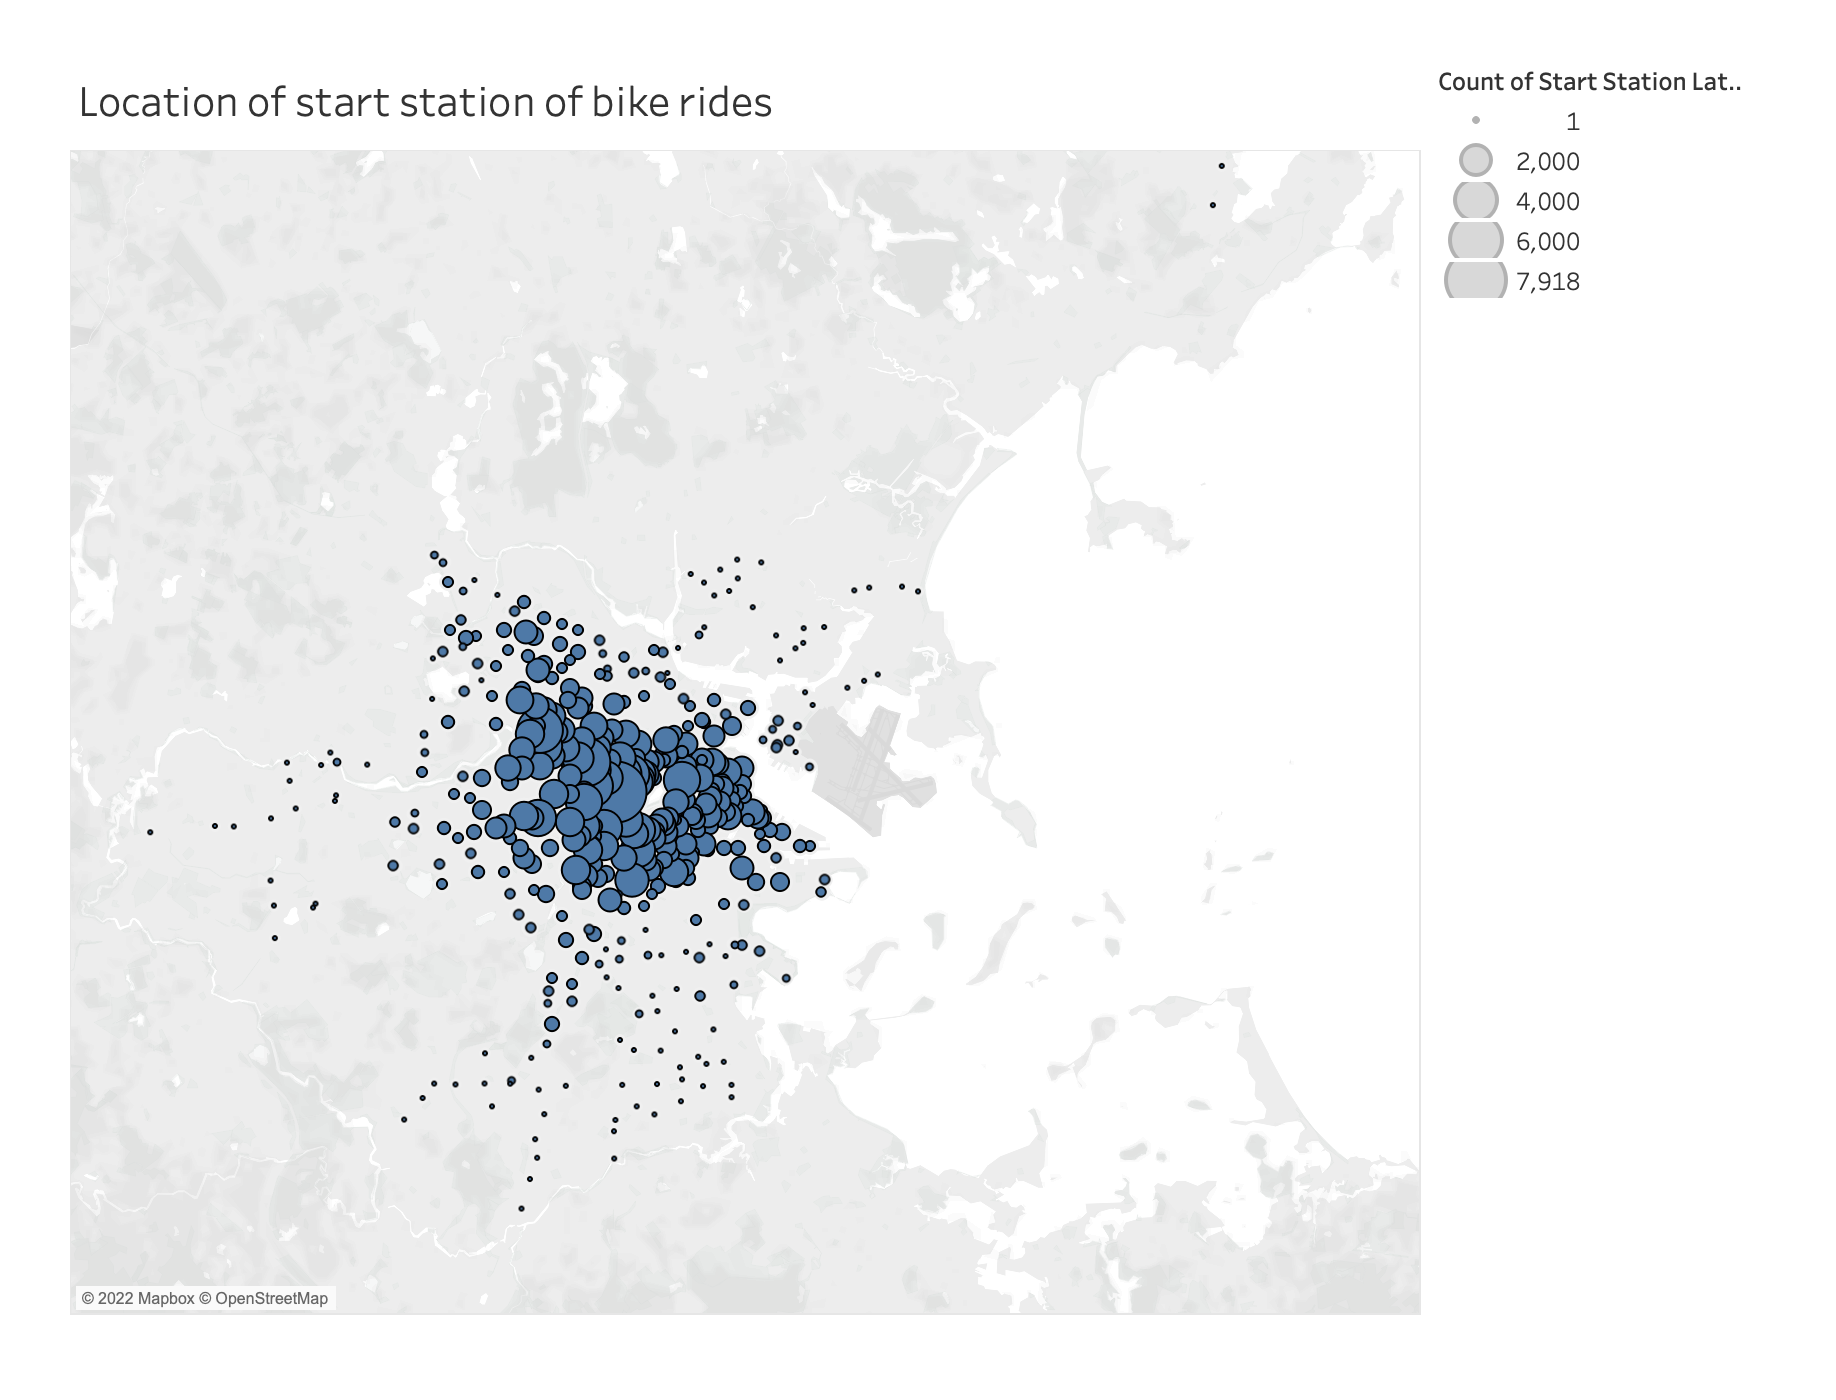

As we can see, most bike trip start stations (the location which is used to associate bike trip data with weather data) are relatively concentrated around Downtown Boston and Cambridge. Therefore, even though some bike trips are a bit further away from one of the 6 weather stations we have data for, the large majority of bike trips started from a station close to a weather station that we have data for.

#Data Quality

Here, we will import the data and needed packages. We will then look for different data quality metrics, and try to prepare the data for the next steps.

## Importing Modules

In [ ]:
# imports 
import pandas as pd
import pandas.util.testing as tm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cbook

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


We opted not to use tensorflow data visualization because it wasn't able to be ran on Google Colab.

## Loading the data

In [ ]:
url = "https://raw.githubusercontent.com/eastmountaincode/bikeshareAndWeather/main/bikeshareAndWeather.csv"
df=pd.read_csv(url, index_col=0)
display(df.head())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,30,38,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


tripduration                 starttime  ... windspeedHigh  windspeedLow
0           178  2021-11-01 00:00:04.0950  ...          17.0           0.0
1           337  2021-11-01 00:00:06.6150  ...          16.0           0.0
2          9922  2021-11-01 00:00:06.6610  ...          16.0           0.0
3           562  2021-11-01 00:00:09.0080  ...          17.0           0.0
4          8989  2021-11-01 00:00:14.3900  ...           9.0           0.0

[5 rows x 53 columns]

## Preliminary steps in removing low quality data



There is one problem with this dataset: I had to stop the script that associated bike trip data with weather data prematurely for time constraint reasons. Therefore, there are many rows which have NaNs for weather data. Let's remove these rows.

If we set the threshhold to 28, this will remove rows where weather data wasn't able to be associated with bike trip data, but will keep rows where weather data was just partially imcomplete, for example, missing 3 or 4 columns. Thresh set to 28 means that any rows with 28 NaNs or more will be dropped.

In [ ]:
df.shape

(250925, 53)

In [ ]:
df = df.dropna(axis="index", thresh = 28)

In [ ]:
df.shape

(108639, 53)

In [ ]:
# This creates a list where each element is an integer representing the number 
# of NaNs in a row. 
list1 = df.isnull().sum(axis=1).tolist()
print("Length of rows:", len(list1))
print("The most number of NaNs in a row is:", max(list1))

# This shows that the maximum number of NaNs in any row of the dataset is
# now 10.

Length of rows: 108639
The most number of NaNs in a row is: 10


Next, we should take note of the column called qcStatus.

From weatherunderground API documentation:
https://docs.google.com/document/d/1w8jbqfAk0tfZS5P7hYnar1JiitM0gQZB-clxDfG3aD0/edit

~~~~~~~~~~~~~~~~~~~~
qcStatus

Quality control indicator:

-1: No quality control check performed

 0: This observation was marked as possibly incorrect by our quality control algorithm

 1: This observation passed quality control checks

~~~~~~~~~~~~~~~~~~~

Based on this, I think we should remove all rows with qcStatus of -1 or 0.

Now we remove rows that have a qcStatus of -1 or 0.

In [ ]:
df = df[df.qcStatus == 1]

In [ ]:
df = df.reset_index(drop=True)

Now that we've removed rows where the qcStatus was -1 or 0, let's get some evidence that the operation worked.

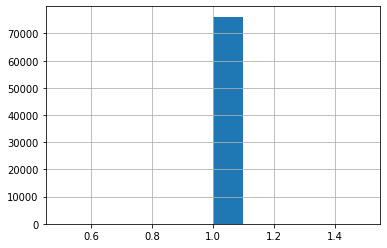

In [ ]:
df['qcStatus'].hist()

In [ ]:
df['qcStatus'].value_counts()

1.0    76164
Name: qcStatus, dtype: int64

In [ ]:
df.shape

(76164, 53)

As we see, there are 76164 total rows, and there are 76164 rows with a qcStatus of 1. Looks good!

Now we can remove qcStatus, since this won't be helpful for predicting trip duration.

In [ ]:
# removing unwanted features

def remove_features(dataframe,feature_name_list):
    """
    Deleting a features from dataframe
    """
    for feature_name in feature_name_list:
        try:
            del dataframe[feature_name]
        except:
            print("Can't delete feature %s" % (feature_name))          


In [ ]:
# removing the feature from the dataset
remove_features(df,['qcStatus'])

In [ ]:
df.shape

(76164, 52)

We should also remove features that won't be helpful in predicting trip duration. It may be desirable to keep the start and end station name columns so that we can see which stations occur most frequently.

In [ ]:
# removing the feature from the dataset
remove_features(df,['start station id', 'end station id', 'bikeid', 'epoch', 'lat', 'lon',
                    'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude',
                    'obsTimeUtc', 'tz', 'winddirAvg'])
df.head()

tripduration                 starttime  ... windspeedHigh windspeedLow
0           178  2021-11-01 00:00:04.0950  ...          17.0          0.0
1          9922  2021-11-01 00:00:06.6610  ...          16.0          0.0
2           562  2021-11-01 00:00:09.0080  ...          17.0          0.0
3          8989  2021-11-01 00:00:14.3900  ...           9.0          0.0
4          8938  2021-11-01 00:00:32.7410  ...           9.0          0.0

[5 rows x 39 columns]

In [ ]:
df.shape

(76164, 39)

## Size of data and column names after the preliminary cleaning


In [ ]:
# What does this tell you? Why isn't it df.shape()?
print(df.shape)

# What are the variable names?
X=df.columns.values.tolist()
print(X)

# How many variables?
print(len(X))

(76164, 39)
['tripduration', 'starttime', 'stoptime', 'start station name', 'end station name', 'usertype', 'postal code', 'startStationDistrict', 'endStationDistrict', 'dewptAvg', 'dewptHigh', 'dewptLow', 'heatindexAvg', 'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh', 'humidityLow', 'obsTimeLocal', 'precipRate', 'precipTotal', 'pressureMax', 'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'stationID', 'tempAvg', 'tempHigh', 'tempLow', 'uvHigh', 'windchillAvg', 'windchillHigh', 'windchillLow', 'windgustAvg', 'windgustHigh', 'windgustLow', 'windspeedAvg', 'windspeedHigh', 'windspeedLow']
39


We have 76164 rows and 39 columns (39 variables).

## Checking for missing values and zero values

In [ ]:
# Find missing values. What does this tell you?
missing_values_count = df.isnull().sum()
missing_values_count

tripduration                0
starttime                   0
stoptime                    0
start station name          0
end station name            0
usertype                    0
postal code              4687
startStationDistrict      677
endStationDistrict        692
dewptAvg                    0
dewptHigh                   0
dewptLow                    0
heatindexAvg                0
heatindexHigh               0
heatindexLow                0
humidityAvg                 0
humidityHigh                0
humidityLow                 0
obsTimeLocal                0
precipRate                  0
precipTotal                 0
pressureMax             22428
pressureMin             22428
pressureTrend           22428
solarRadiationHigh      37595
stationID                   0
tempAvg                     0
tempHigh                    0
tempLow                     0
uvHigh                  22428
windchillAvg                0
windchillHigh               0
windchillLow                0
windgustAv

We have many missing values. About half of solarRadiationHigh values are missing. We should think about how to correct this (imputing data, removing rows, etc.)

In [ ]:
# Find zero values. What does this tell you? Does this make sense?
zero_values_count = df.isin([0]).sum()
zero_values_count

tripduration                0
starttime                   0
stoptime                    0
start station name          0
end station name            0
usertype                    0
postal code                 0
startStationDistrict        0
endStationDistrict          0
dewptAvg                    0
dewptHigh                   0
dewptLow                    0
heatindexAvg                0
heatindexHigh               0
heatindexLow                0
humidityAvg                 0
humidityHigh                0
humidityLow                 0
obsTimeLocal                0
precipRate              74473
precipTotal             74473
pressureMax                 0
pressureMin                 0
pressureTrend           21595
solarRadiationHigh          0
stationID                   0
tempAvg                     0
tempHigh                    0
tempLow                     0
uvHigh                      0
windchillAvg                0
windchillHigh               0
windchillLow                0
windgustAv

Every column that contains zeros is holding a variable that has a meaningful zero, so there isn't anything we need to correct here.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76164 entries, 0 to 76163
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tripduration          76164 non-null  int64  
 1   starttime             76164 non-null  object 
 2   stoptime              76164 non-null  object 
 3   start station name    76164 non-null  object 
 4   end station name      76164 non-null  object 
 5   usertype              76164 non-null  object 
 6   postal code           71477 non-null  object 
 7   startStationDistrict  75487 non-null  object 
 8   endStationDistrict    75472 non-null  object 
 9   dewptAvg              76164 non-null  float64
 10  dewptHigh             76164 non-null  float64
 11  dewptLow              76164 non-null  float64
 12  heatindexAvg          76164 non-null  float64
 13  heatindexHigh         76164 non-null  float64
 14  heatindexLow          76164 non-null  float64
 15  humidityAvg        

In [ ]:
# Identify object columns
print("OBJECTS:")
print(df.select_dtypes(['object']).columns)
print()

print("NUMERIC:")
# Identify integer and float columns
print(df.select_dtypes(['int64', 'float64']).columns)

OBJECTS:
Index(['starttime', 'stoptime', 'start station name', 'end station name',
       'usertype', 'postal code', 'startStationDistrict', 'endStationDistrict',
       'obsTimeLocal', 'stationID'],
      dtype='object')

NUMERIC:
Index(['tripduration', 'dewptAvg', 'dewptHigh', 'dewptLow', 'heatindexAvg',
       'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh',
       'humidityLow', 'precipRate', 'precipTotal', 'pressureMax',
       'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'tempAvg',
       'tempHigh', 'tempLow', 'uvHigh', 'windchillAvg', 'windchillHigh',
       'windchillLow', 'windgustAvg', 'windgustHigh', 'windgustLow',
       'windspeedAvg', 'windspeedHigh', 'windspeedLow'],
      dtype='object')


According to the Pandas documentation: 

"The categorical data type is useful in the following cases: A string variable consisting of only a few different values..."

Columns with only a few categories like usertype can be converted into categories. Columns like postal code with many different variations probably shouldn't be converted into a category.

In [ ]:
# Convert objects to categorical variables
actually_categorical = ['usertype', 'startStationDistrict', 'endStationDistrict', 'stationID']                       
for col in actually_categorical:
    df[col] = df[col].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76164 entries, 0 to 76163
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   tripduration          76164 non-null  int64   
 1   starttime             76164 non-null  object  
 2   stoptime              76164 non-null  object  
 3   start station name    76164 non-null  object  
 4   end station name      76164 non-null  object  
 5   usertype              76164 non-null  category
 6   postal code           71477 non-null  object  
 7   startStationDistrict  75487 non-null  category
 8   endStationDistrict    75472 non-null  category
 9   dewptAvg              76164 non-null  float64 
 10  dewptHigh             76164 non-null  float64 
 11  dewptLow              76164 non-null  float64 
 12  heatindexAvg          76164 non-null  float64 
 13  heatindexHigh         76164 non-null  float64 
 14  heatindexLow          76164 non-null  float64 
 15  hu

## Dealing with date fields

In [ ]:
# Convert to date object
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['obsTimeLocal'] = pd.to_datetime(df['obsTimeLocal'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76164 entries, 0 to 76163
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tripduration          76164 non-null  int64         
 1   starttime             76164 non-null  datetime64[ns]
 2   stoptime              76164 non-null  datetime64[ns]
 3   start station name    76164 non-null  object        
 4   end station name      76164 non-null  object        
 5   usertype              76164 non-null  category      
 6   postal code           71477 non-null  object        
 7   startStationDistrict  75487 non-null  category      
 8   endStationDistrict    75472 non-null  category      
 9   dewptAvg              76164 non-null  float64       
 10  dewptHigh             76164 non-null  float64       
 11  dewptLow              76164 non-null  float64       
 12  heatindexAvg          76164 non-null  float64       
 13  heatindexHigh   

These data types make sense. Columns related to date and/or time are now of the datatype type. Columns with string data that refers to one of a few different categories are now of the category type. Columns with string data that refers to one of many different categories have remained as the object type. 

## Descriptive statistics

In [ ]:
# Descriptive statistics
descriptive_statistics=df.describe()
descriptive_statistics

tripduration      dewptAvg  ...  windspeedHigh  windspeedLow
count  7.616400e+04  76164.000000  ...   76163.000000       76163.0
mean   1.415094e+03     35.940615  ...      10.852947           0.0
std    2.752308e+04      4.799933  ...       9.120752           0.0
min    6.100000e+01     29.000000  ...       0.000000           0.0
25%    3.770000e+02     32.000000  ...       7.000000           0.0
50%    6.090000e+02     36.000000  ...       9.000000           0.0
75%    1.016000e+03     41.000000  ...      13.000000           0.0
max    2.815170e+06     44.000000  ...      68.000000           0.0

[8 rows x 29 columns]

Most of these statistics all seem to make sense. The mean trip duration is 1469 seconds (24 minutes). The min trip duration is 1 minute. The **max trip duration**, however, is 2815170, which is 782 hours. This is going to skew our dataset, so we should consider removing outliers to doing something to adjust our dataset for a more accurate representation of bike trip durations. The 75th percentile is a reasonable number, 1021 seconds or 17 minutes. Therefore it's likely that we only have a few extremely large outliers like our max of 2815170, and removing those extremely large values shouldn't be too damaging to our dataset.

## Removing Outliers

Based on what was found in the descriptive statistics sections, we should probably take a look at the distribution of trip durations.

In [ ]:
import matplotlib.pyplot as plt

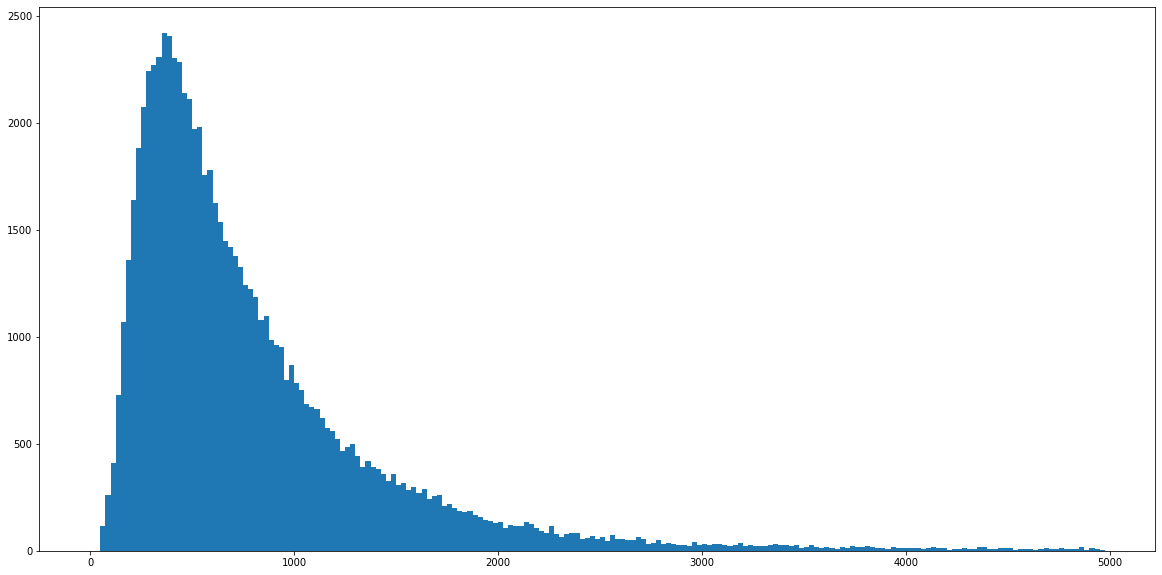

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(df['tripduration'], bins = [x for x in range(0, 5000, 25)]); #Semicolon used to suppress verbose output

This histogram shows a normal distribution that is positively skewed. We can see that the max value of 2815170 is most certainly an outlier. We should remove outliers.

Let's remove outliers based on the traditional statistics practice of removing values that are greater than Q3 + (1.5 * IQR) and less than Q1 - (1.5 * IQR)

In [ ]:
def outlier_treatment(datacolumn):
  sorted(datacolumn)
  Q1,Q3 = np.percentile(datacolumn , [25,75])
  IQR = Q3 - Q1
  print(IQR)
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [ ]:
lowerbound,upperbound = outlier_treatment(df['tripduration'])

639.0


In [ ]:
lowerbound

-581.5

In [ ]:
upperbound

1974.5

In [ ]:
df = df[df['tripduration'] < upperbound]
df = df[df['tripduration'] > lowerbound]

Let's check out the results.

In [ ]:
# Descriptive statistics
descriptive_statistics=df.describe()
descriptive_statistics

tripduration      dewptAvg  ...  windspeedHigh  windspeedLow
count  71289.000000  71289.000000  ...   71288.000000       71288.0
mean     683.130483     35.987754  ...      10.929722           0.0
std      416.184719      4.799668  ...       9.146415           0.0
min       61.000000     29.000000  ...       0.000000           0.0
25%      365.000000     32.000000  ...       7.000000           0.0
50%      573.000000     36.000000  ...       9.000000           0.0
75%      911.000000     41.000000  ...      13.000000           0.0
max     1974.000000     44.000000  ...      68.000000           0.0

[8 rows x 29 columns]

The max tripduration is now 1974 seconds, which is 0.548 hours.

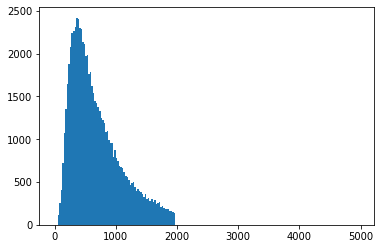

In [ ]:
plt.hist(df['tripduration'], bins = [x for x in range(0, 5000, 25)]); #Semicolon used to suppress verbose output

## Skewness

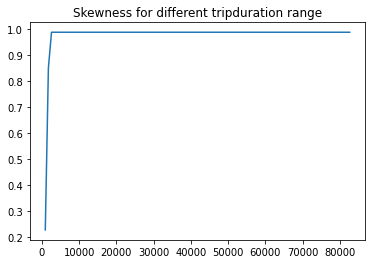

In [ ]:
# What does this tell you?
# NOTE: 61 is the min and 82644 for is the max for tripduration
x = np.linspace(61, 82644, num=100)

y = [df[(df['tripduration'] < x_range)]['tripduration'].skew() for x_range in x]
sns.lineplot(x=x,y=y)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Skewness for different tripduration range')
plt.show()


We would expect trip durations to be normally distributed, as very short and vey long trips are quite rare.
As we saw in our table, trip durations were skewed low. The outlier trip durations seemed to be the reason.
Our  zeros are all for variables that do have meaningful zeros.

## Correlation between the features

In [ ]:
#Correlation between the features
corr = df.corr()
corr

tripduration  dewptAvg  ...  windspeedHigh  windspeedLow
tripduration            1.000000 -0.042970  ...      -0.004742           NaN
dewptAvg               -0.042970  1.000000  ...      -0.006136           NaN
dewptHigh              -0.033024  0.963043  ...       0.002595           NaN
dewptLow               -0.050369  0.906070  ...      -0.047650           NaN
heatindexAvg           -0.053286  0.942819  ...      -0.025119           NaN
heatindexHigh          -0.014952  0.826736  ...      -0.221655           NaN
heatindexLow           -0.080052  0.750890  ...       0.066823           NaN
humidityAvg             0.056892 -0.189581  ...      -0.009306           NaN
humidityHigh            0.057104  0.192336  ...       0.169091           NaN
humidityLow            -0.063406  0.269604  ...       0.199140           NaN
precipRate              0.013864  0.158285  ...       0.084024           NaN
precipTotal             0.013864  0.158285  ...       0.084024           NaN
pressureMax             0.075930 -0.866001  ...       0.227698           NaN
pressureMin             0.048556 -0.806224  ...       0.068850           NaN
pressureTrend          -0.044293  0.044551  ...       0.281864           NaN
solarRadiationHigh     -0.006034 -0.121083  ...       0.782962           NaN
tempAvg                -0.052924  0.943931  ...      -0.029522           NaN
tempHigh               -0.014989  0.826744  ...      -0.219755           NaN
tempLow                -0.080052  0.750890  ...       0.066823           NaN
uvHigh                 -0.031504  0.128586  ...       0.048542           NaN
windchillAvg           -0.050701  0.949152  ...      -0.032911           NaN
windchillHigh          -0.014989  0.826744  ...      -0.219755           NaN
windchillLow           -0.062044  0.830115  ...      -0.007510           NaN
windgustAvg            -0.065330  0.242050  ...       0.215430           NaN
windgustHigh           -0.022774 -0.067834  ...       0.985389           NaN
windgustLow                  NaN       NaN  ...            NaN           NaN
windspeedAvg           -0.039410  0.313630  ...       0.295659           NaN
windspeedHigh          -0.004742 -0.006136  ...       1.000000           NaN
windspeedLow                 NaN       NaN  ...            NaN           NaN

[29 rows x 29 columns]

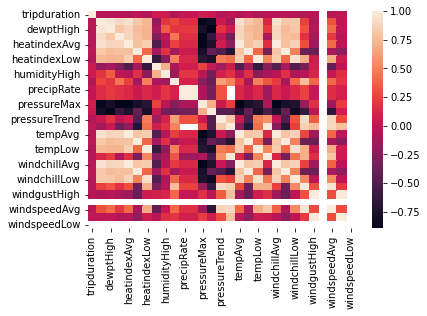

In [ ]:
sns.heatmap(corr)

Some weather related data, like pressure and heatindex seem to have negative or positive correlations. This makes sense, although, I am not an expert in this.
A negative correlation means that when one value goes up, the other goes down.

##Categorical value counts

In [ ]:
vc=df['start station name'].value_counts()
vc

MIT at Mass Ave / Amherst St             2086
Central Square at Mass Ave / Essex St    1599
Harvard Square at Mass Ave/ Dunster      1450
Commonwealth Ave at Agganis Way          1122
MIT Vassar St                            1100
                                         ... 
Roseland St At Dorchester Ave               1
Washington St at Bowdoin St                 1
Washington St at Fuller St                  1
Centre St at Parkway YMCA                   1
Blue Hill Ave at Havelock St                1
Name: start station name, Length: 398, dtype: int64

In [ ]:
# Calculate the proportion (i.e. probability) of each class
col='usertype'
vc_prob=pd.DataFrame(df[col].value_counts(normalize=True))
vc_prob.index.name = col
vc_prob.columns = ['Probability']
vc_prob


Probability
usertype               
Subscriber     0.841027
Customer       0.158973

In [ ]:
number_of_categories=vc_prob.shape[0]
print(number_of_categories)

2


## Entropy

Here, the idea of entropy is explained with some examples.

Given the probability of each of n events, the information required to predict an event is the distribution’s **entropy**. 

Low entropy means the system is very ordered, that is, very predictable. 

High entropy means the system is mixed, that is, very unpredictable; a lot of information is needed for prediction.

Shannon entropy is a measure of uncertainty.

If we are completely certain of an outcome P(X)=1 or P(X) = 1 the Shannon entropy will be zero. If we are completely uncertain of an outcome P(X) = 0.5  then the Shannon entropy will take its maximum value of 1.

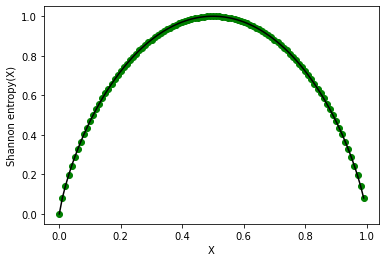

In [ ]:
def shannon_entropy(p):   
    return (-p *np.log2(p) - (1-p)*np.log2(1-p))

base=0.0000000001
x = np.arange(base, 1.0-base, 0.01)


plt.figure(1)
plt.plot(x, shannon_entropy(x), 'go', x, shannon_entropy(x), 'k')
plt.ylabel('Shannon entropy(X)')
plt.xlabel('X')
plt.show()


1. If a categorical variable had just one value what do you think the normalized Shannon entropy would be?

  **Answer**: It will be zero, since we are certain about the outcome which is the only value.

2. Create a function like ``shannon_entropy(p)`` called ``gini_coefficienty(p)`` that creates a Gini coefficient versus probability plot.



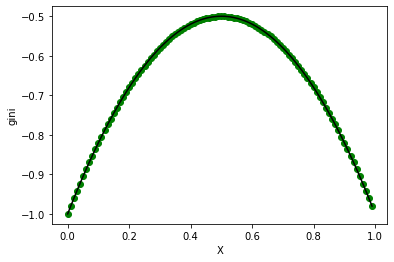

In [ ]:
def gini(p):   
    return -(p**2 + (1-p)**2)

base=0.0000000001
x = np.arange(base, 1.0-base, 0.01)


plt.figure(1)
plt.plot(x, gini(x), 'go', x, gini(x), 'k')
plt.ylabel('gini')
plt.xlabel('X')
plt.show()

#Feature Selection

Here, we will use the Variance Threshold and Pearson correlation methods for feature selection from SK Learn package before we start our modeling.

##Variance Threshold

In [ ]:
#Import modules
import pandas as pd
from sklearn.feature_selection import VarianceThreshold


Variance threshold is not applicable to timestamps or categorical variables. we should remove these.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71289 entries, 0 to 76163
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tripduration          71289 non-null  int64         
 1   starttime             71289 non-null  datetime64[ns]
 2   stoptime              71289 non-null  datetime64[ns]
 3   start station name    71289 non-null  object        
 4   end station name      71289 non-null  object        
 5   usertype              71289 non-null  category      
 6   postal code           67275 non-null  object        
 7   startStationDistrict  70652 non-null  category      
 8   endStationDistrict    70647 non-null  category      
 9   dewptAvg              71289 non-null  float64       
 10  dewptHigh             71289 non-null  float64       
 11  dewptLow              71289 non-null  float64       
 12  heatindexAvg          71289 non-null  float64       
 13  heatindexHigh   

In [ ]:
df_for_variance_threshold=df.drop(['starttime','stoptime','obsTimeLocal',
                                'start station name','end station name',
                                'usertype','postal code','startStationDistrict',
                                'endStationDistrict','stationID']
                               ,axis=1)
variance_threshold = VarianceThreshold(threshold=0)
variance_threshold.fit(df_for_variance_threshold)


VarianceThreshold(threshold=0)

Now, Let's see which columns were constant values

In [ ]:
variance_threshold.get_support() #False indicate the constant values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False])

In [ ]:
df_for_variance_threshold.columns[variance_threshold.get_support()]

Index(['tripduration', 'dewptAvg', 'dewptHigh', 'dewptLow', 'heatindexAvg',
       'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh',
       'humidityLow', 'precipRate', 'precipTotal', 'pressureMax',
       'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'tempAvg',
       'tempHigh', 'tempLow', 'uvHigh', 'windchillAvg', 'windchillHigh',
       'windchillLow', 'windgustAvg', 'windgustHigh', 'windspeedAvg',
       'windspeedHigh'],
      dtype='object')

In [ ]:
constant_columns = [column for column in df_for_variance_threshold.columns
                    if column not in df_for_variance_threshold.columns[variance_threshold.get_support()]]

print(len(constant_columns))  #checking the number of constant columns

2


In [ ]:
#column names which have constant values
for feature in constant_columns:
  print(feature) 

windgustLow
windspeedLow


In [ ]:
#Dropping the columns having constant values
df=df.drop(constant_columns,axis=1)

##Pearson Correlation

We will remove highly correlated features here.

In [ ]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df.corr()

tripduration  dewptAvg  ...  windspeedAvg  windspeedHigh
tripduration            1.000000 -0.042970  ...     -0.039410      -0.004742
dewptAvg               -0.042970  1.000000  ...      0.313630      -0.006136
dewptHigh              -0.033024  0.963043  ...      0.410611       0.002595
dewptLow               -0.050369  0.906070  ...      0.215762      -0.047650
heatindexAvg           -0.053286  0.942819  ...      0.407089      -0.025119
heatindexHigh          -0.014952  0.826736  ...     -0.105867      -0.221655
heatindexLow           -0.080052  0.750890  ...      0.685500       0.066823
humidityAvg             0.056892 -0.189581  ...     -0.411928      -0.009306
humidityHigh            0.057104  0.192336  ...      0.027616       0.169091
humidityLow            -0.063406  0.269604  ...      0.402970       0.199140
precipRate              0.013864  0.158285  ...      0.164891       0.084024
precipTotal             0.013864  0.158285  ...      0.164891       0.084024
pressureMax             0.075930 -0.866001  ...     -0.145500       0.227698
pressureMin             0.048556 -0.806224  ...     -0.672000       0.068850
pressureTrend          -0.044293  0.044551  ...      0.885884       0.281864
solarRadiationHigh     -0.006034 -0.121083  ...      0.902447       0.782962
tempAvg                -0.052924  0.943931  ...      0.389677      -0.029522
tempHigh               -0.014989  0.826744  ...     -0.109275      -0.219755
tempLow                -0.080052  0.750890  ...      0.685500       0.066823
uvHigh                 -0.031504  0.128586  ...      0.808797       0.048542
windchillAvg           -0.050701  0.949152  ...      0.370862      -0.032911
windchillHigh          -0.014989  0.826744  ...     -0.109275      -0.219755
windchillLow           -0.062044  0.830115  ...      0.545035      -0.007510
windgustAvg            -0.065330  0.242050  ...      0.961726       0.215430
windgustHigh           -0.022774 -0.067834  ...      0.289540       0.985389
windspeedAvg           -0.039410  0.313630  ...      1.000000       0.295659
windspeedHigh          -0.004742 -0.006136  ...      0.295659       1.000000

[27 rows x 27 columns]

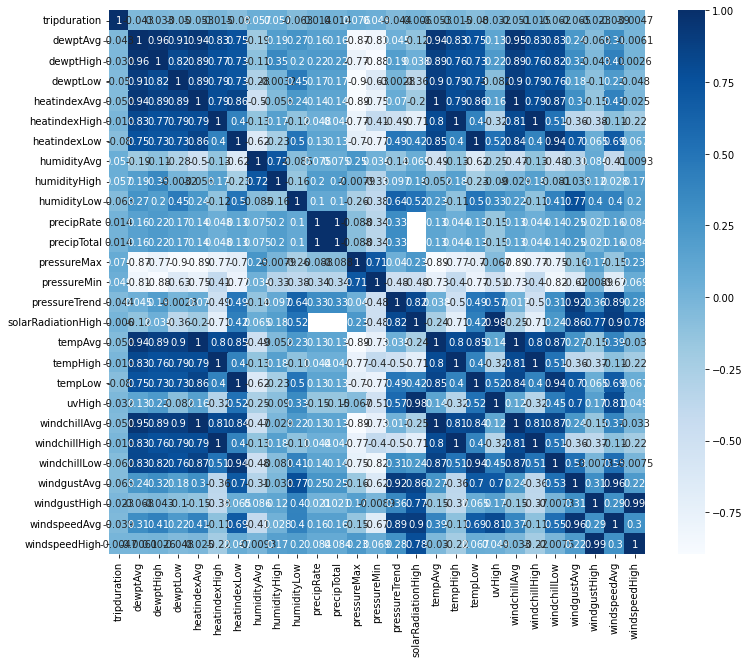

In [ ]:
# Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor,annot=True, cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Selecting highly correlated feature, this will remove the first feature which is highly correlated with the other feature
def correlation(dataset, threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        colname =  corr_matrix.columns[i] #getting column names
        col_corr.add(colname)

  return col_corr     

In [ ]:
corr_features = correlation(df, 0.9) #setting threshold to 0.9
len(set(corr_features)) 
#to check the number of features which are highly correlated

14

In [ ]:
corr_features

{'dewptHigh',
 'dewptLow',
 'heatindexAvg',
 'precipTotal',
 'tempAvg',
 'tempHigh',
 'tempLow',
 'uvHigh',
 'windchillAvg',
 'windchillHigh',
 'windchillLow',
 'windgustAvg',
 'windspeedAvg',
 'windspeedHigh'}

In [ ]:
df=df.drop(corr_features,axis=1)

#Modeling

We will first prepare our data and then use H2O autoML to train models.

## One-Hot Encoding Categorical Data

I would like to be able to use this categorical data such as usertype and startStationDistrict/endStationDistrict. Let's one-hot encode our categorical data.

In [ ]:
catList = ['usertype', 'startStationDistrict', 'endStationDistrict']

for i in catList:
  x = pd.get_dummies(df[i], prefix=i)
  df = pd.concat([df, x], axis=1)
  df.drop([i],axis=1, inplace=True)

In [ ]:
df

tripduration  ... endStationDistrict_Watertown
0               178  ...                            0
2               562  ...                            0
5               524  ...                            0
6              1369  ...                            0
8              1080  ...                            0
...             ...  ...                          ...
76159           949  ...                            0
76160          1527  ...                            0
76161           135  ...                            0
76162           633  ...                            0
76163          1213  ...                            0

[71289 rows x 44 columns]

In [ ]:
df.shape

(71289, 44)

## Removing null values

I would like to bring this data into H20 to investigate feature importance, but we still have some null values. We can (1) impute all the columns with null values with the mean of the column except for postal code, in which case I think we'll have to (2) remove the null rows. Let's do that.

In [ ]:
missing_values_count = df.isnull().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_values_count)

tripduration                           0
starttime                              0
stoptime                               0
start station name                     0
end station name                       0
postal code                         4014
dewptAvg                               0
heatindexHigh                          0
heatindexLow                           0
humidityAvg                            0
humidityHigh                           0
humidityLow                            0
obsTimeLocal                           0
precipRate                             0
pressureMax                        20928
pressureMin                        20928
pressureTrend                      20928
solarRadiationHigh                 35148
stationID                              0
windgustHigh                       20928
usertype_Customer                      0
usertype_Subscriber                    0
startStationDistrict_Arlington         0
startStationDistrict_Boston            0
startStationDist

In [ ]:
df = df.dropna(subset=['postal code'])

In [ ]:
missing_values_count = df.isnull().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_values_count)

tripduration                           0
starttime                              0
stoptime                               0
start station name                     0
end station name                       0
postal code                            0
dewptAvg                               0
heatindexHigh                          0
heatindexLow                           0
humidityAvg                            0
humidityHigh                           0
humidityLow                            0
obsTimeLocal                           0
precipRate                             0
pressureMax                        19740
pressureMin                        19740
pressureTrend                      19740
solarRadiationHigh                 33182
stationID                              0
windgustHigh                       19740
usertype_Customer                      0
usertype_Subscriber                    0
startStationDistrict_Arlington         0
startStationDistrict_Boston            0
startStationDist

The columns in which there are remaining null values are now:


In [ ]:
df.columns[df.isna().any()].tolist()

['pressureMax',
 'pressureMin',
 'pressureTrend',
 'solarRadiationHigh',
 'windgustHigh']

## Initializing AutoML

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 175.8 MB 30 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.7-py2.py3-none-any.whl size=175908084 sha256=fb85fd9655e41cda43f29dad01354d6621e68c2b1af6bc1fb3484b19ff279120
  Stored in directory: /root/.cache/pip/wheels/df/df/05/1f2ac68a5d9bf38b74f2b8218443b2c00f1a5f4f3154ec11b6
Successfully built h2o


In [ ]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [ ]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)


6
Checking whether there is an H2O instance running at http://localhost:7317 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzx_7ek3s
  JVM stdout: /tmp/tmpzx_7ek3s/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzx_7ek3s/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:7317
Connecting to H2O server at http://127.0.0.1:7317 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.34.0.7
H2O_cluster_version_age:    1 month
H2O_cluster_name:           H2O_from_python_unknownUser_460cbs
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:7317
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.12 final
--------------------------  ------------------------------------------------------------------

In [ ]:
hf = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
hf.head()

tripduration starttime stoptime start station name end station name postal code dewptAvg heatindexHigh heatindexLow humidityAvg humidityHigh humidityLow obsTimeLocal precipRate pressureMax pressureMin pressureTrend solarRadiationHigh stationID windgustHigh usertype_Customer usertype_Subscriber startStationDistrict_Arlington startStationDistrict_Boston startStationDistrict_Brookline startStationDistrict_Cambridge startStationDistrict_Chelsea startStationDistrict_Everett startStationDistrict_Newton startStationDistrict_Revere startStationDistrict_Salem startStationDistrict_Somerville startStationDistrict_Watertown endStationDistrict_Arlington endStationDistrict_Boston endStationDistrict_Brookline endStationDistrict_Cambridge endStationDistrict_Chelsea endStationDistrict_Everett endStationDistrict_Newton endStationDistrict_Revere endStationDistrict_Salem endStationDistrict_Somerville endStationDistrict_Watertown 
 
 
 178 2021-11-01 00:00:04 2021-11-01 00:03:02 Washington St at Waltham St Harrison Ave at Mullins Way 2118 42 60 49 63 90 42 2021-11-01 00:00:00 0 30.2 29.72 0.02 521.4 KMABOSTO326 22 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 
 562 2021-11-01 00:00:09 2021-11-01 00:09:31 Boylston St at Dartmouth St Northeastern University - North Parking Lot 33146 42 60 49 63 90 42 2021-11-01 00:00:00 0 30.2 29.72 0.02 521.4 KMABOSTO326 22 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 
 1080 2021-11-01 00:01:13 2021-11-01 00:19:13 MIT at Mass Ave / Amherst St Beacon St at Washington / Kirkland 48375 42 60 49 63 90 42 2021-11-01 00:00:00 0 30.2 29.72 0.02 521.4 KMABOSTO326 22 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 
 1100 2021-11-01 00:01:14 2021-11-01 00:19:34 MIT at Mass Ave / Amherst St Beacon St at Washington / Kirkland 2143 42 60 49 63 90 42 2021-11-01 00:00:00 0 30.2 29.72 0.02 521.4 KMABOSTO326 22 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 
 197 2021-11-01 00:01:31 2021-11-01 00:04:49 MIT Vassar St Sidney Research Campus/Erie Street at Waverly 2139 41 62 44 66 90 41 2021-11-01 00:00:00 0.01 30.22 29.75 0.02 nan KMABROOK44 16 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 
 326 2021-11-01 00:01:42 2021-11-01 00:07:09 Child St at North St Blossom St at Charles St 2141 42 60 49 63 90 42 2021-11-01 00:00:00 0 30.2 29.72 0.02 521.4 KMABOSTO326 22 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 
 499 2021-11-01 00:01:55 2021-11-01 00:10:14 Landmark Center - Brookline Ave at Park Dr Longwood Ave at Binney St 2120 41 62 44 66 90 41 2021-11-01 00:00:00 0.01 30.22 29.75 0.02 nan KMABROOK44 16 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 
 212 2021-11-01 00:02:17 2021-11-01 00:05:49 Beacon St at Charles St Clarendon St at Newbury St 2116 42 60 49 63 90 42 2021-11-01 00:00:00 0 30.2 29.72 0.02 521.4 KMABOSTO326 22 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 
 1409 2021-11-01 00:02:22 2021-11-01 00:25:51 Lewis Wharf at Atlantic Ave Boylston St at Jersey St 2215 42 60 49 63 90 42 2021-11-01 00:00:00 0 30.2 29.72 0.02 521.4 KMABOSTO326 22 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 
 1884 2021-11-01 00:02:27 2021-11-01 00:33:52 Clarendon St at Newbury St Shawmut T Stop 2124 42 60 49 63 90 42 2021-11-01 00:00:00 0 30.2 29.72 0.02 521.4 KMABOSTO326 22 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0

## Train/test split

In [ ]:
# Create a 80/20 train/test split
pct_rows=0.80
hf_train, hf_test = hf.split_frame([pct_rows])

In [ ]:
print(hf_train.shape)
print(hf_test.shape)

(53728, 44)
(13547, 44)


## Imputing null data

Now impute.

In [ ]:
mean_impute = hf_train.impute(method = 'mean')
mean_impute = hf_test.impute(method = 'mean')

In [ ]:
print('missing:', hf_train.isna().sum())

missing: 0.0


In [ ]:
print('missing:', hf_test.isna().sum())

missing: 0.0


## Set features and predictor

In [ ]:
# Set the features and target
X=hf.columns
print(X)

['tripduration', 'starttime', 'stoptime', 'start station name', 'end station name', 'postal code', 'dewptAvg', 'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh', 'humidityLow', 'obsTimeLocal', 'precipRate', 'pressureMax', 'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'stationID', 'windgustHigh', 'usertype_Customer', 'usertype_Subscriber', 'startStationDistrict_Arlington', 'startStationDistrict_Boston', 'startStationDistrict_Brookline', 'startStationDistrict_Cambridge', 'startStationDistrict_Chelsea', 'startStationDistrict_Everett', 'startStationDistrict_Newton', 'startStationDistrict_Revere', 'startStationDistrict_Salem', 'startStationDistrict_Somerville', 'startStationDistrict_Watertown', 'endStationDistrict_Arlington', 'endStationDistrict_Boston', 'endStationDistrict_Brookline', 'endStationDistrict_Cambridge', 'endStationDistrict_Chelsea', 'endStationDistrict_Everett', 'endStationDistrict_Newton', 'endStationDistrict_Revere', 'endStationDistrict_Salem', 'endStati

In [ ]:
# Set target and predictor variables
y ='tripduration'
X.remove(y) 
print(X)

['starttime', 'stoptime', 'start station name', 'end station name', 'postal code', 'dewptAvg', 'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh', 'humidityLow', 'obsTimeLocal', 'precipRate', 'pressureMax', 'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'stationID', 'windgustHigh', 'usertype_Customer', 'usertype_Subscriber', 'startStationDistrict_Arlington', 'startStationDistrict_Boston', 'startStationDistrict_Brookline', 'startStationDistrict_Cambridge', 'startStationDistrict_Chelsea', 'startStationDistrict_Everett', 'startStationDistrict_Newton', 'startStationDistrict_Revere', 'startStationDistrict_Salem', 'startStationDistrict_Somerville', 'startStationDistrict_Watertown', 'endStationDistrict_Arlington', 'endStationDistrict_Boston', 'endStationDistrict_Brookline', 'endStationDistrict_Cambridge', 'endStationDistrict_Chelsea', 'endStationDistrict_Everett', 'endStationDistrict_Newton', 'endStationDistrict_Revere', 'endStationDistrict_Salem', 'endStationDistrict_Somer

## Run AutoML

In [ ]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [ ]:
aml.train(x=X,y=y,training_frame=hf_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_2_AutoML_1_20220121_222438

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 35727.115406410085
RMSE: 189.01617763146646
MAE: 129.70947857181082
RMSLE: 0.3203071255651894
R^2: 0.7899143861515601
Mean Residual Deviance: 35727.115406410085
Null degrees of freedom: 9939
Residual degrees of freedom: 9936
Null deviance: 1690395427.0992274
Residual deviance: 355127527.13971627
AIC: 132426.13027383338

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 77966.43471285183
RMSE: 279.224702905835
MAE: 192.3518261187878
RMSLE: 0.4302953138067339
R^2: 0.5423036997467994
Mean Residual Deviance: 77966.43471285183
Null degrees of freedom: 53727
Residual degrees of freedom: 53724
Null deviance: 9152617316.23

In [ ]:
print(aml.leaderboard)

model_id mean_residual_deviance rmse mse mae rmsle 
 
 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220121_222438 77966.4 279.225 77966.4 192.352 0.430295 
 StackedEnsemble_AllModels_1_AutoML_1_20220121_222438 77966.8 279.225 77966.8 192.365 0.430308 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220121_222438 78084.4 279.436 78084.4 192.63 0.430827 
 GBM_1_AutoML_1_20220121_222438 79770.1 282.436 79770.1 195.438 0.434746 
 XGBoost_1_AutoML_1_20220121_222438 108510 329.409 108510 245.494 0.52369 
 GBM_3_AutoML_1_20220121_222438 123177 350.966 123177 271.049 0.569565 
 GBM_2_AutoML_1_20220121_222438 123574 351.531 123574 271.81 0.570629 
 XGBoost_2_AutoML_1_20220121_222438 125021 353.583 125021 264.712 0.550914 
 GBM_4_AutoML_1_20220121_222438 127724 357.384 127724 277.344 0.578497 
 DRF_1_AutoML_1_20220121_222438 164295 405.334 164295 271.789 0.59952

In [ ]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GBM_1_AutoML_1_20220121_222438': 3,
 'GLM_1_AutoML_1_20220121_222438': 10,
 'StackedEnsemble_AllModels_1_AutoML_1_20220121_222438': 1,
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20220121_222438': 2,
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20220121_222438': 0}

In [ ]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

3


In [ ]:
best_model.algo

'gbm'

# Feature Importance and Interpretation

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo 
 
 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220121_222438 77966.4 279.225 77966.4 192.352 0.430295 1214 0.030636 StackedEnsemble 
 StackedEnsemble_AllModels_1_AutoML_1_20220121_222438 77966.8 279.225 77966.8 192.365 0.430308 1237 0.030497 StackedEnsemble 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220121_222438 78084.4 279.436 78084.4 192.63 0.430827 1502 0.029415 StackedEnsemble 
 GBM_1_AutoML_1_20220121_222438 79770.1 282.436 79770.1 195.438 0.434746 11661 0.023472 GBM 
 XGBoost_1_AutoML_1_20220121_222438 108510 329.409 108510 245.494 0.52369 8574 0.00576 XGBoost 
 GBM_3_AutoML_1_20220121_222438 123177 350.966 123177 271.049 0.569565 1002 0.003137 GBM 
 GBM_2_AutoML_1_20220121_222438 123574 351.531 123574 271.81 0.570629 1068 0.003717 GBM 
 XGBoost_2_AutoML_1_20220121_222438 125021 353.583 125021 264.712 0.550914 1225 0.001587 XGBoost 
 GBM_4_AutoML_1_20220121_222438 127724 357.384 127724 277.344 0.578497 984 0.002415 GBM 
 DRF_1_AutoML_1_20220121_222438 164295 405.334 164295 271.789 0.59952 1584 0.001472 DRF 
 GLM_1_AutoML_1_20220121_222438 170325 412.704 170325 330.043 0.661534 932 0.000985 GLM 
 XGBoost_3_AutoML_1_20220121_222438 380278 616.667 380278 476.175 1.1921 473 0.001037 XGBoost

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

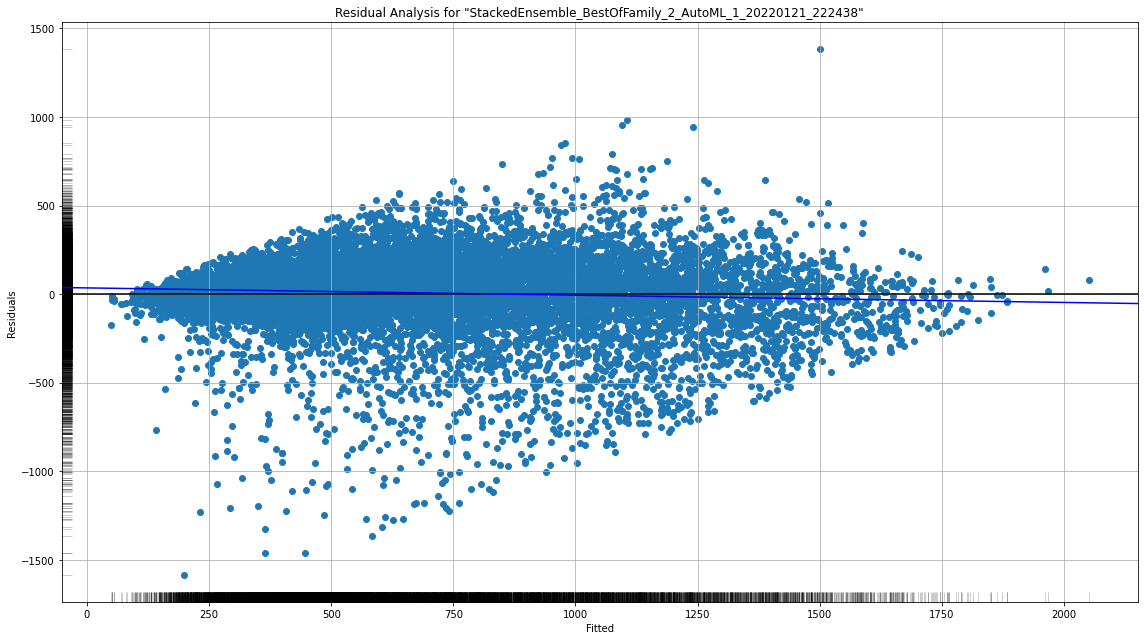

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

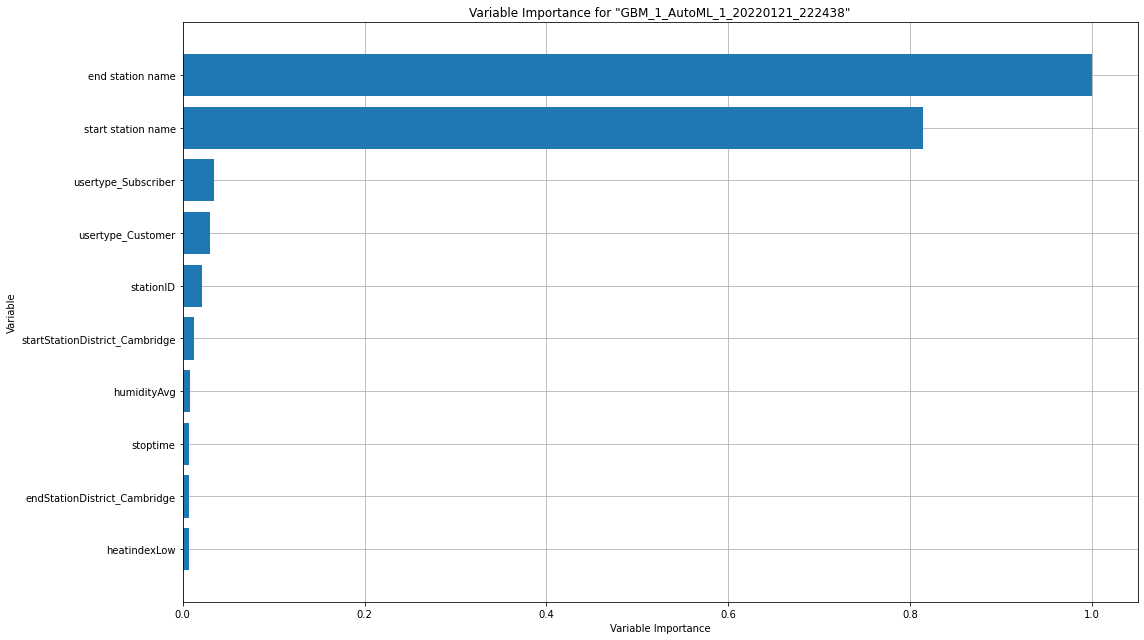

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

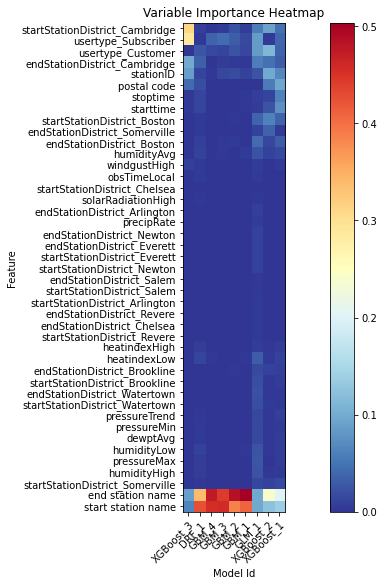

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

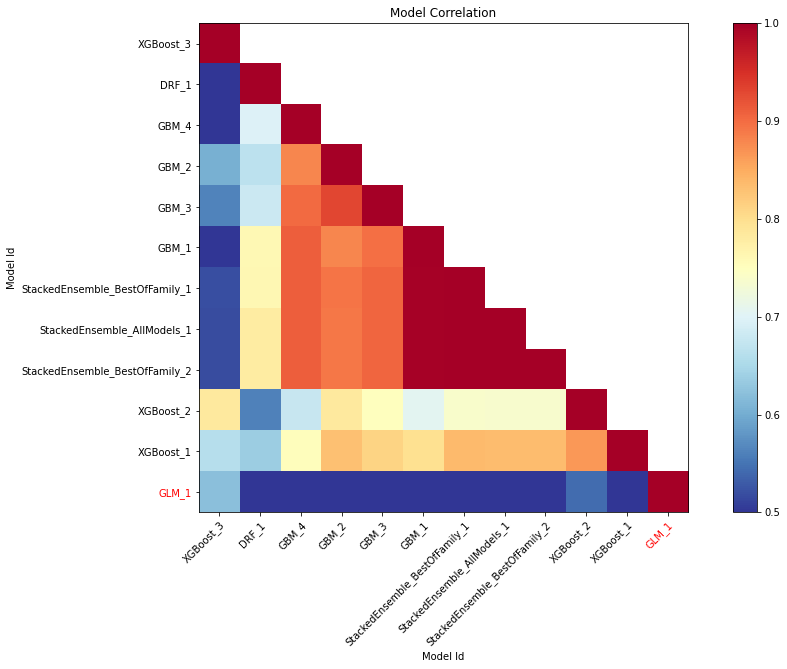

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

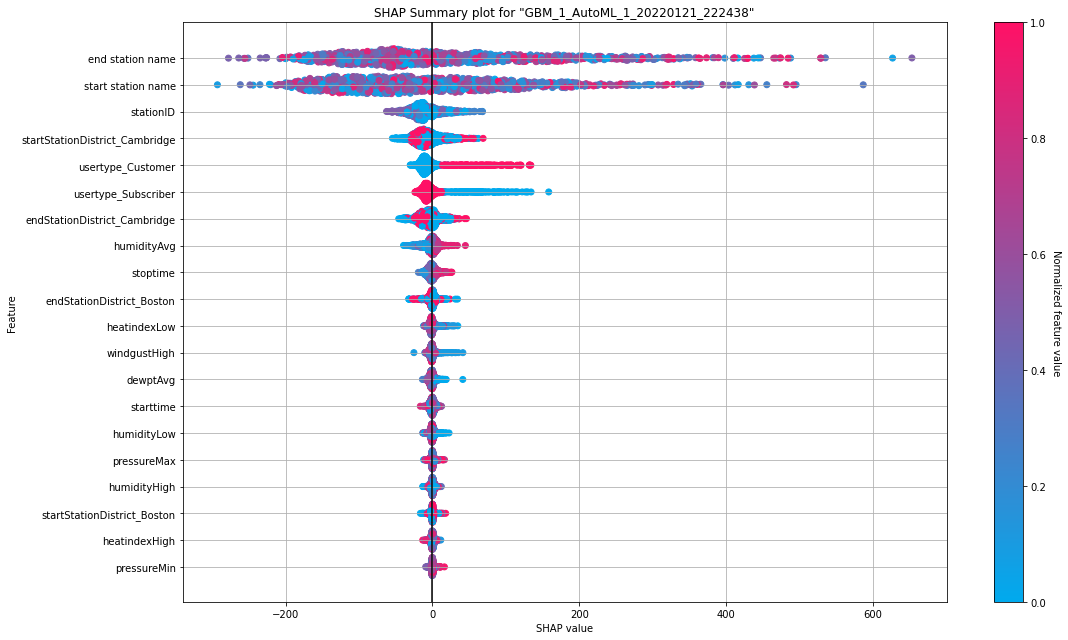

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

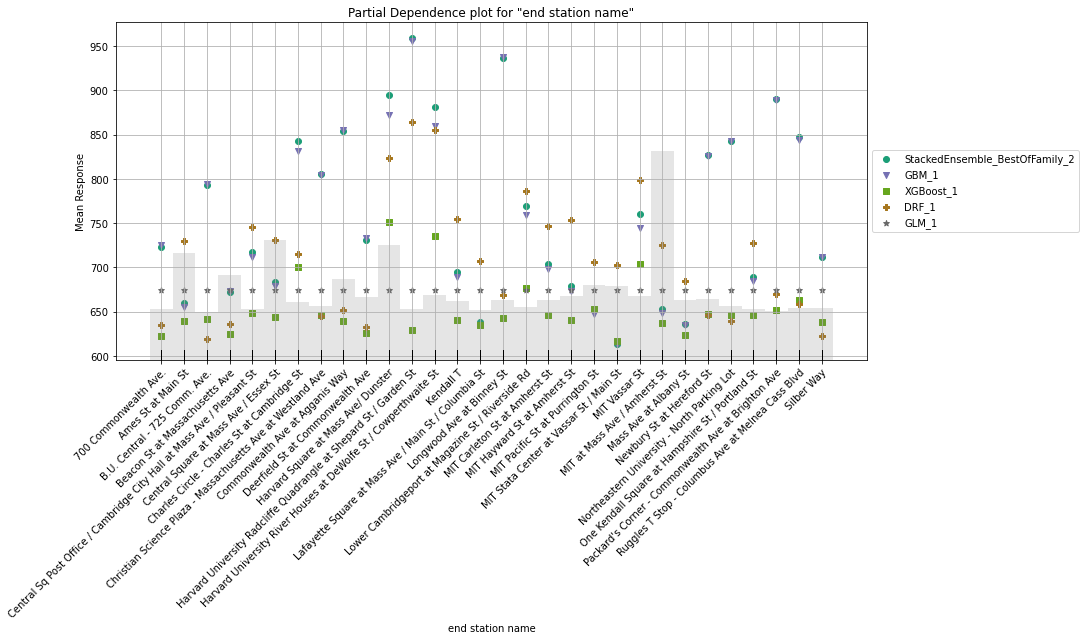

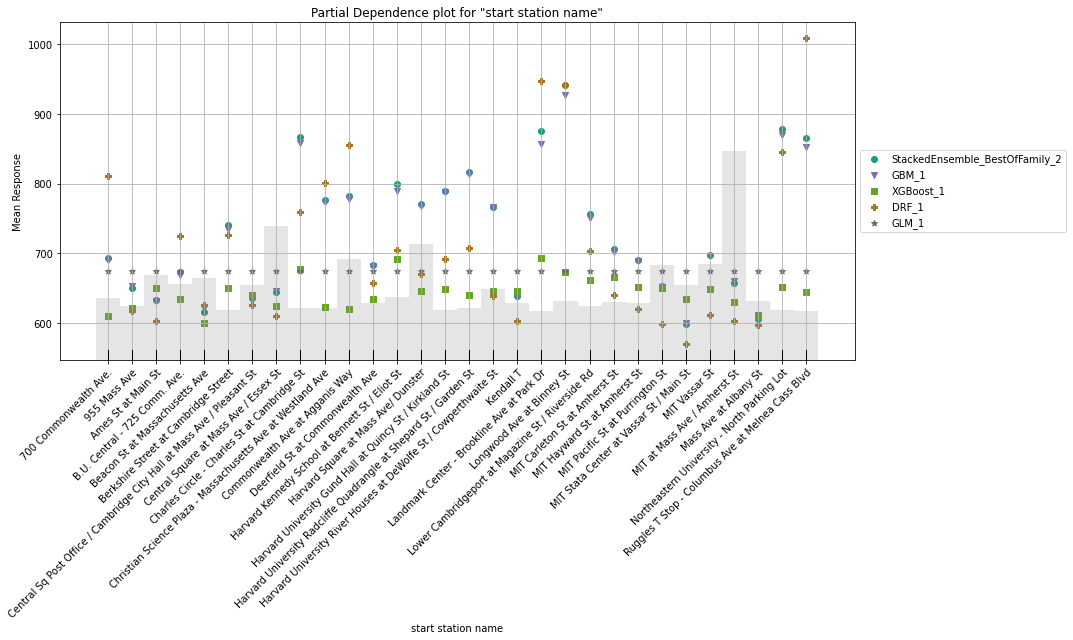

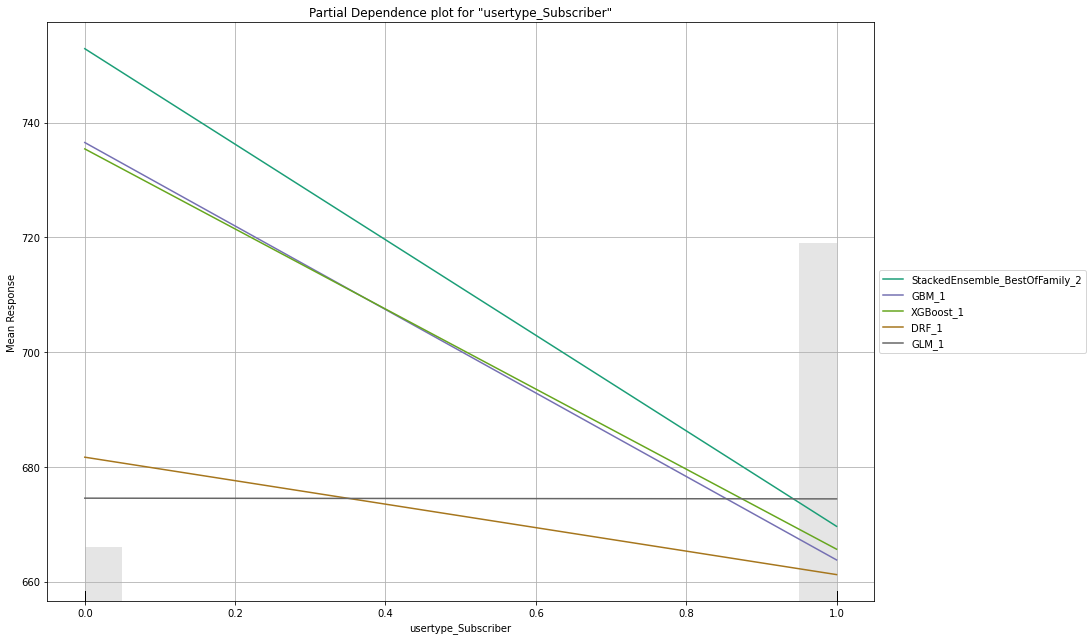

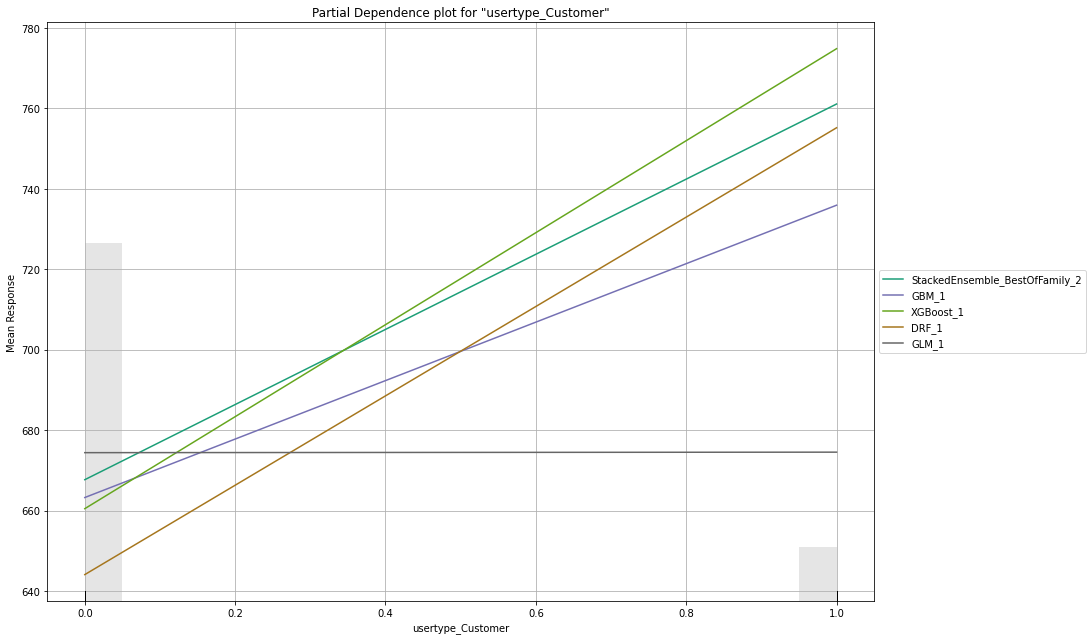

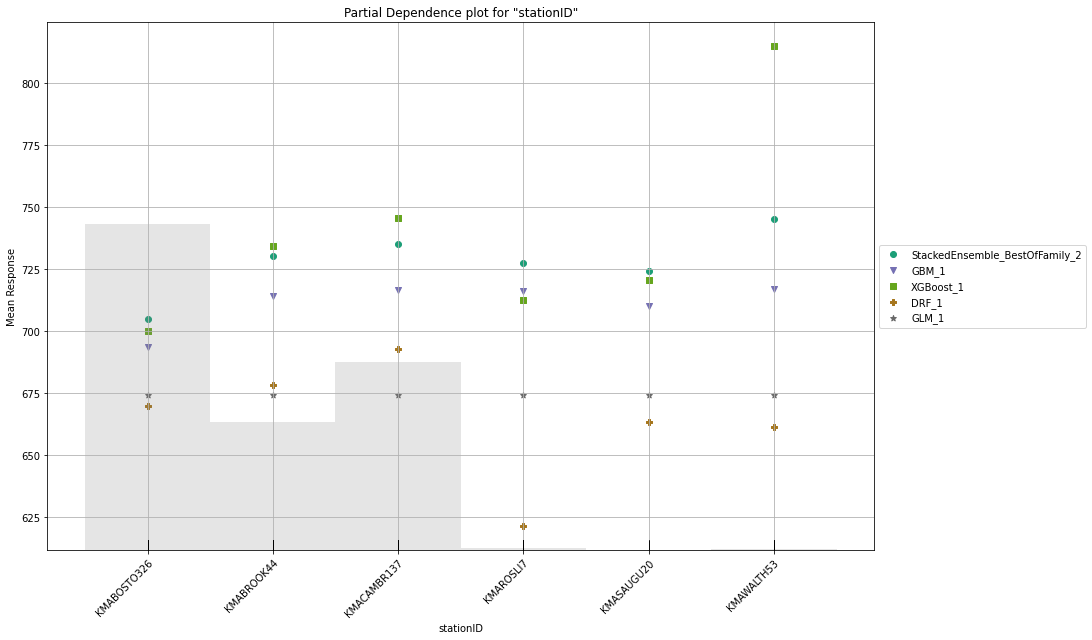

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

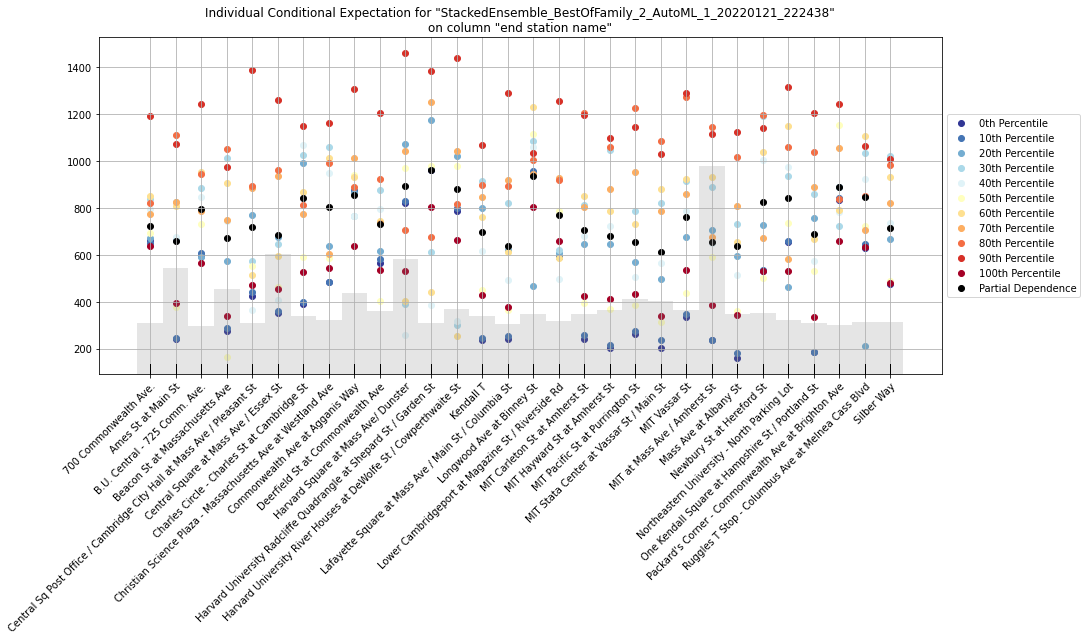

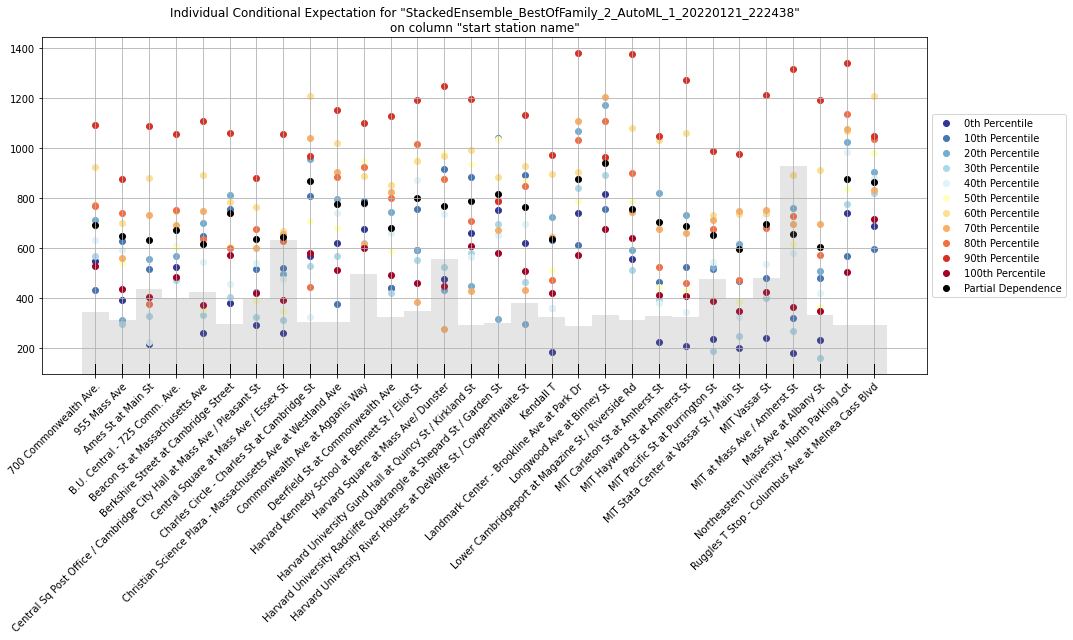

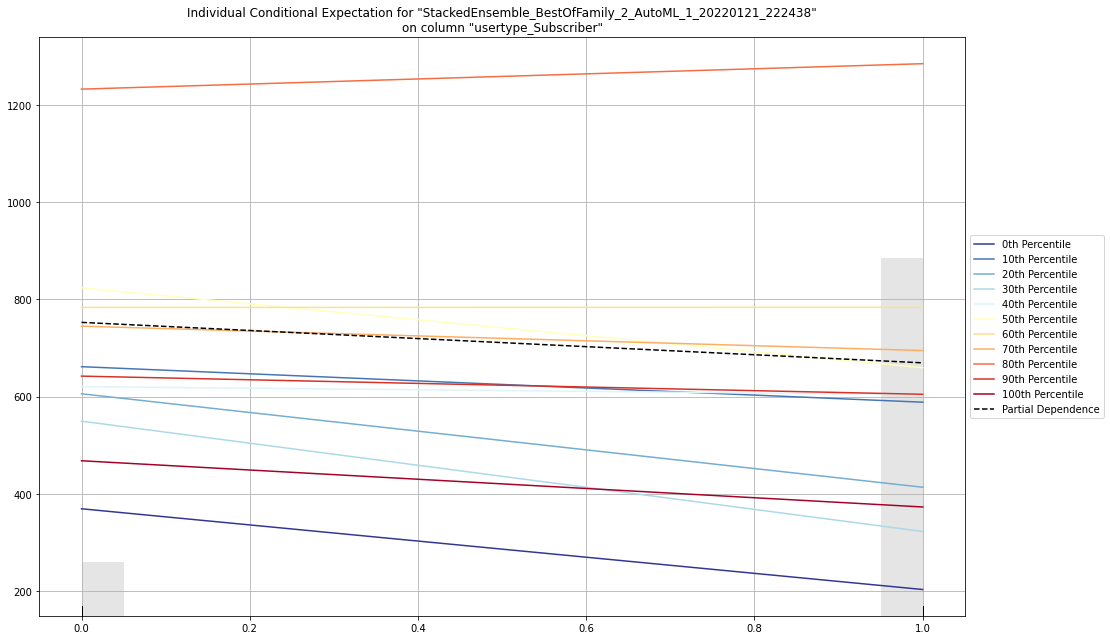

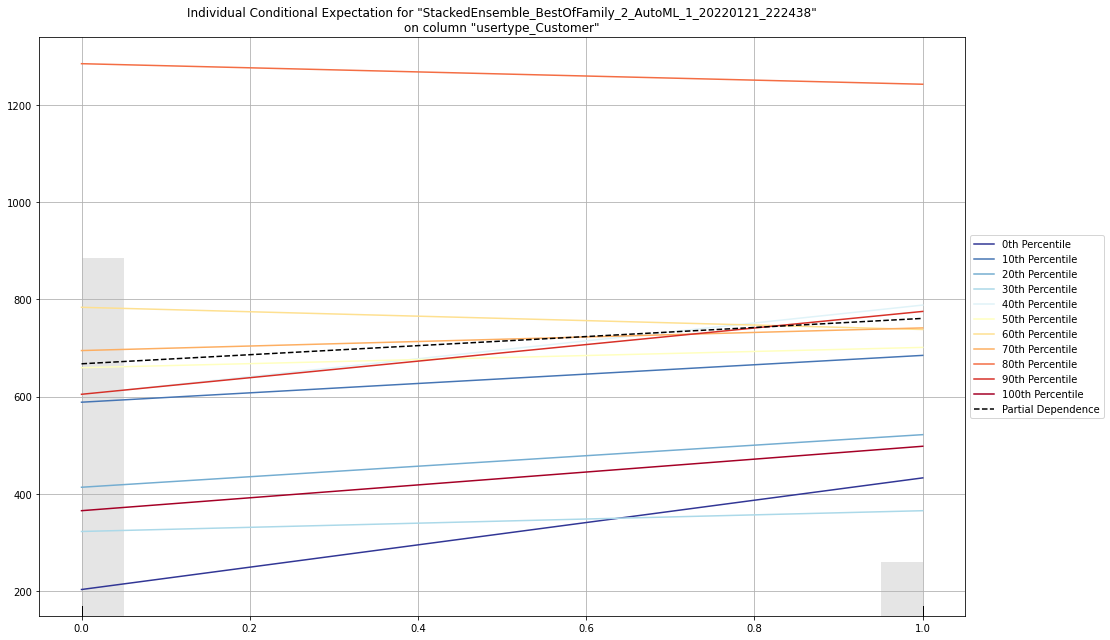

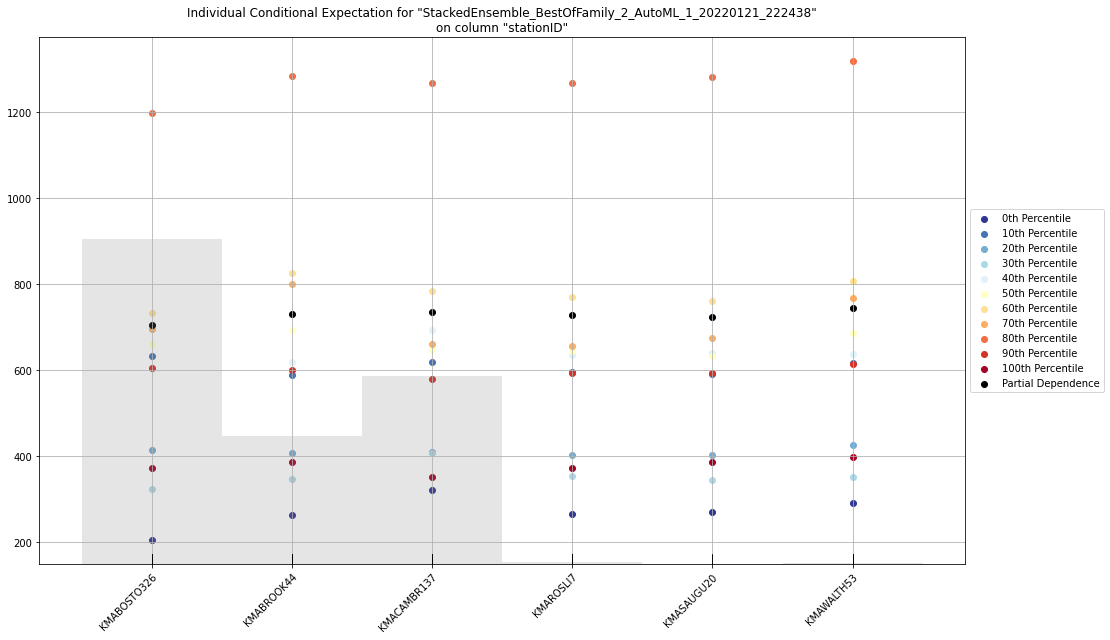

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo 
 
 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220121_222438 77966.4 279.225 77966.4 192.352 0.430295 1214 0.030636 StackedEnsemble 
 StackedEnsemble_AllModels_1_AutoML_1_20220121_222438 77966.8 279.225 77966.8 192.365 0.430308 1237 0.030497 StackedEnsemble 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220121_222438 78084.4 279.436 78084.4 192.63 0.430827 1502 0.029415 StackedEnsemble 
 GBM_1_AutoML_1_20220121_222438 79770.1 282.436 79770.1 195.438 0.434746 11661 0.023472 GBM 
 XGBoost_1_AutoML_1_20220121_222438 108510 329.409 108510 245.494 0.52369 8574 0.00576 XGBoost 
 GBM_3_AutoML_1_20220121_222438 123177 350.966 123177 271.049 0.569565 1002 0.003137 GBM 
 GBM_2_AutoML_1_20220121_222438 123574 351.531 123574 271.81 0.570629 1068 0.003717 GBM 
 XGBoost_2_AutoML_1_20220121_222438 125021 353.583 125021 264.712 0.550914 1225 0.001587 XGBoost 
 GBM_4_AutoML_1_20220121_222438 127724 357.384 127724 277.344 0.578497 984 0.002415 GBM 
 DRF_1_AutoML_1_20220121_222438 164295 405.334 164295 271.789 0.59952 1584 0.001472 DRF 
 GLM_1_AutoML_1_20220121_222438 170325 412.704 170325 330.043 0.661534 932 0.000985 GLM 
 XGBoost_3_AutoML_1_20220121_222438 380278 616.667 380278 476.175 1.1921 473 0.001037 XGBoost

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [ ]:
aml.explain(hf_test)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

This graph (below) is showing that which station the rider started and ended at had a big effect on trip duration.




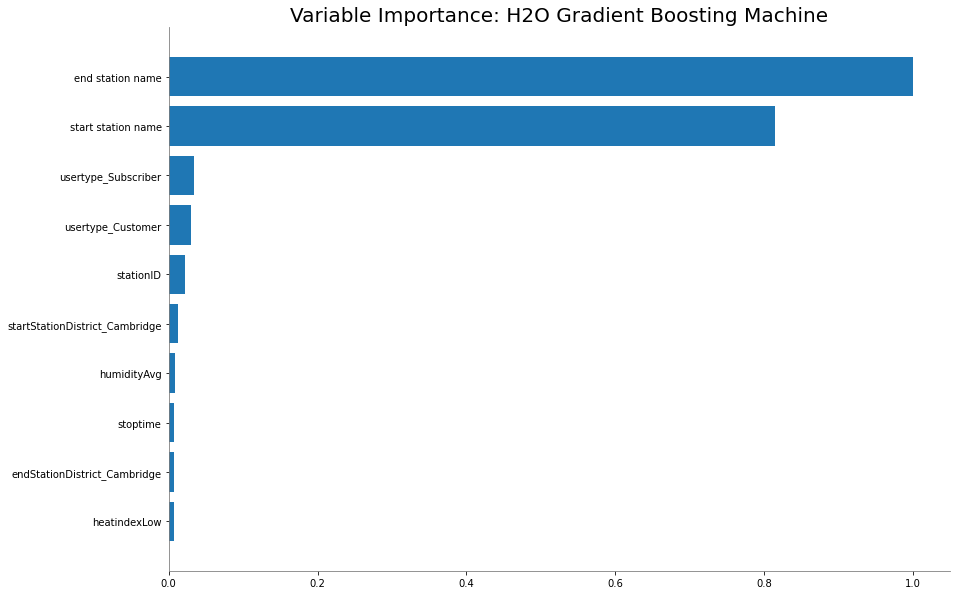

<Figure size 432x288 with 0 Axes>

In [ ]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

This graph (below) is showing that whether or not the user was a subscriber is the most important determinant of tripduration.

10
glm


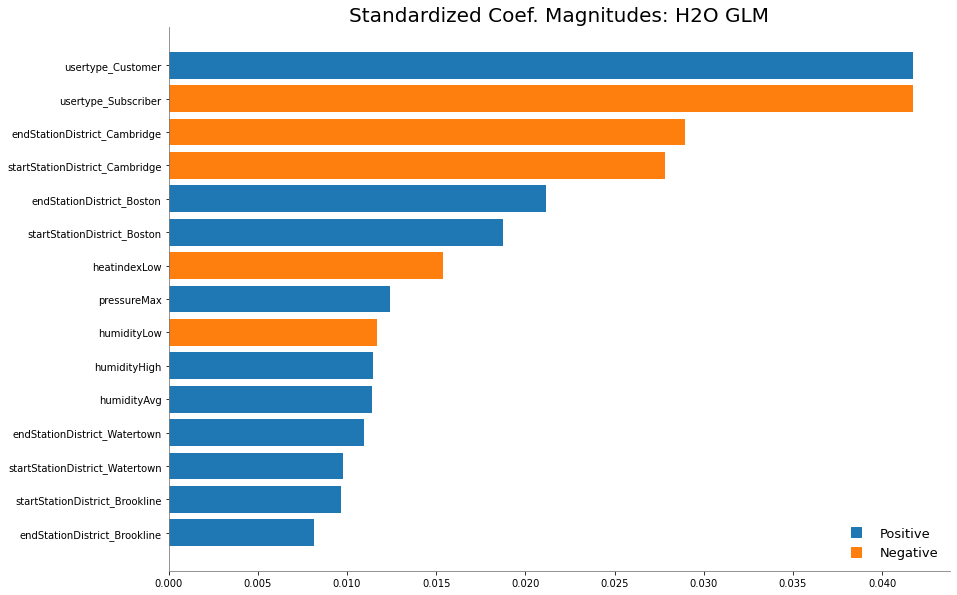

In [ ]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot(num_of_features=15)

It looks like if a user is a subscriber, they are more likely to take shorter trips. This intuitively makes sense; if a user is a subscriber they won't worry about the cost in their choice to make a trip, so they'll make more casual, shorter trips. If a user isn't a subscriber, they'll worry about the cost of an individual trip and only take a trip if it's going to be worth the money.

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model GBM_1_AutoML_1_20220121_222438 on column 'usertype_Customer'.


usertype_customer  mean_response  stddev_response  std_error_mean_response
0                0.0     663.178763       295.572046                 1.139558
1                1.0     736.475275       261.636379                 1.008721

[]

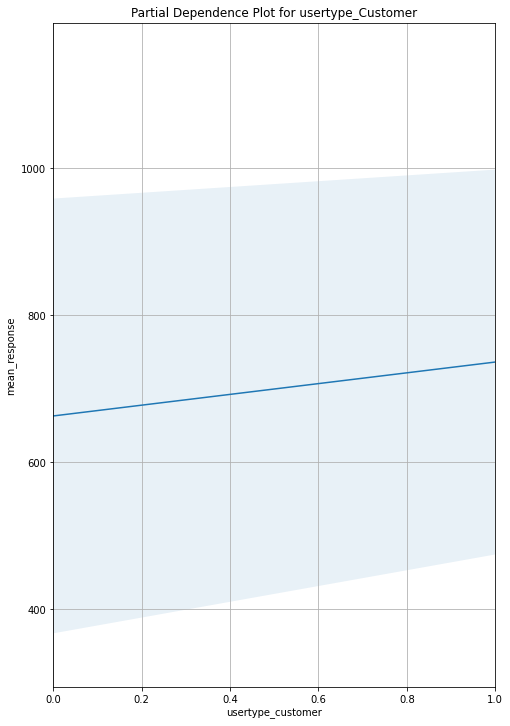

In [ ]:
best_model.partial_plot(hf, cols=['usertype_Customer'])

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model GBM_1_AutoML_1_20220121_222438 on column 'usertype_Subscriber'.


usertype_subscriber  mean_response  stddev_response  std_error_mean_response
0                  0.0     737.844634       266.164920                 1.026181
1                  1.0     663.500606       296.698097                 1.143900

[]

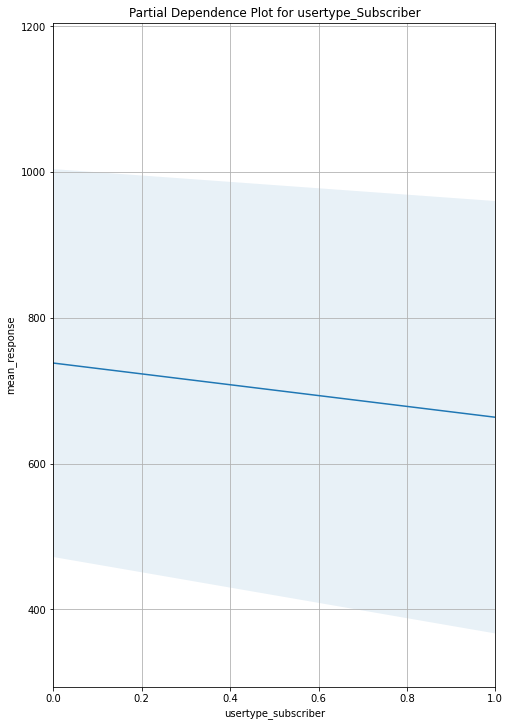

In [ ]:
best_model.partial_plot(hf, cols=['usertype_Subscriber'])

## Average trip duration by start/end station  bar chart

The variable importance graph of the H2O gradient boosting machine showed us that the start/end station name was one of the most important variables for predicting trip duration? Which stations have the longest/shortest trips?

In [ ]:
station_col = ['startStationDistrict_Arlington', 'startStationDistrict_Boston', 'startStationDistrict_Brookline', 'startStationDistrict_Cambridge', 'startStationDistrict_Chelsea', 'startStationDistrict_Everett', 'startStationDistrict_Newton', 'startStationDistrict_Revere', 'startStationDistrict_Salem', 'startStationDistrict_Somerville', 'startStationDistrict_Watertown', 'endStationDistrict_Arlington', 'endStationDistrict_Boston', 'endStationDistrict_Brookline', 'endStationDistrict_Cambridge', 'endStationDistrict_Chelsea', 'endStationDistrict_Everett', 'endStationDistrict_Newton', 'endStationDistrict_Revere', 'endStationDistrict_Salem', 'endStationDistrict_Somerville', 'endStationDistrict_Watertown']
y_axis = [df[df[x] == 1]['tripduration'].mean() for x in station_col]
# data_list = []
# for i in range(len(y_axis)):
#   data_list.append((station))

In [ ]:
df_for_graph = pd.DataFrame({'Labels': station_col,'Values': y_axis}).sort_values(by=['Values'], ascending = False)

In [ ]:
df_for_graph

Labels       Values
21     endStationDistrict_Watertown  1076.167513
10   startStationDistrict_Watertown  1073.347368
15       endStationDistrict_Chelsea   976.826087
5      startStationDistrict_Everett   942.422764
7       startStationDistrict_Revere   924.750000
16       endStationDistrict_Everett   918.495868
19         endStationDistrict_Salem   897.325000
8        startStationDistrict_Salem   897.325000
17        endStationDistrict_Newton   895.562044
6       startStationDistrict_Newton   867.337662
18        endStationDistrict_Revere   863.692308
11     endStationDistrict_Arlington   814.248649
0    startStationDistrict_Arlington   796.021622
2    startStationDistrict_Brookline   769.521968
13     endStationDistrict_Brookline   758.883698
4      startStationDistrict_Chelsea   756.083333
9   startStationDistrict_Somerville   733.846688
20    endStationDistrict_Somerville   718.811163
12        endStationDistrict_Boston   717.694022
1       startStationDistrict_Boston   713.833858
3    startStationDistrict_Cambridge   604.057267
14     endStationDistrict_Cambridge   602.958935

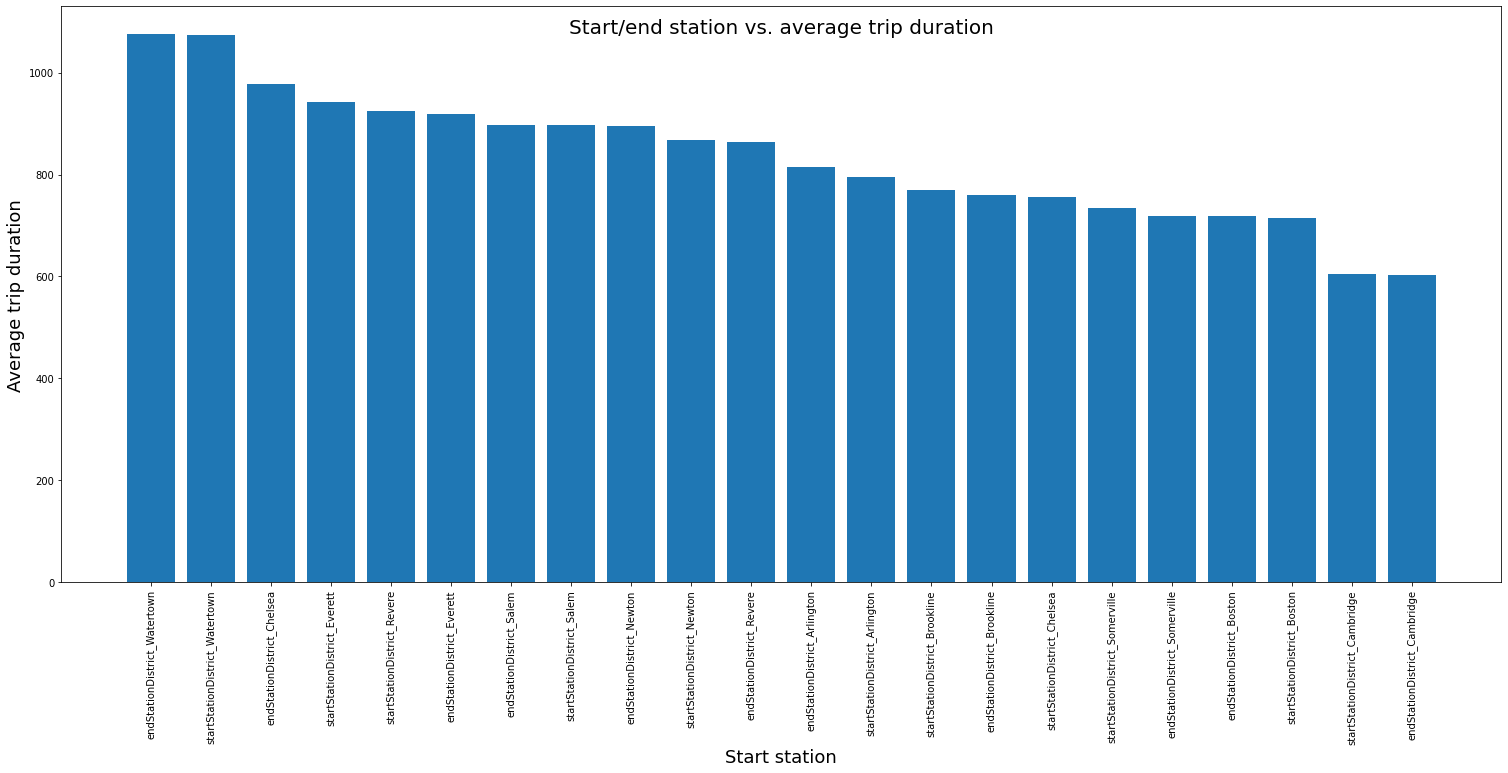

In [ ]:
X = df_for_graph['Labels']
Y = df_for_graph['Values']
fig = plt.figure(figsize = (20, 8))
fig.suptitle('Start/end station vs. average trip duration', fontsize=20)
ax = fig.add_axes([0,0,1,1])
ax.bar(X, Y)
plt.ylabel('Average trip duration', fontsize=18)
plt.xlabel('Start station', fontsize=18)
plt.draw()
ax.set_xticklabels(X, rotation = 90)
plt.show()

We can observe that the longest trips started and ended in Watertown, and the shortest trips started and ended in Cambridge.

# Impute before split?

Would the model perform better if we impute before we split into test/train subsets? Let's find out.

In [ ]:
print('missing:', hf.isna().sum())

missing: 112854.0


In [ ]:
mean_impute = hf.impute(method = 'mean')

In [ ]:
print('missing:', hf.isna().sum())

missing: 0.0


In [ ]:
# Create a 80/20 train/test splie
pct_rows=0.80
hf_train, hf_test = hf.split_frame([pct_rows])

In [ ]:
# Set the features and target
X=hf.columns
print(X)

['tripduration', 'starttime', 'stoptime', 'start station name', 'end station name', 'postal code', 'dewptAvg', 'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh', 'humidityLow', 'obsTimeLocal', 'precipRate', 'pressureMax', 'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'stationID', 'windgustHigh', 'usertype_Customer', 'usertype_Subscriber', 'startStationDistrict_Arlington', 'startStationDistrict_Boston', 'startStationDistrict_Brookline', 'startStationDistrict_Cambridge', 'startStationDistrict_Chelsea', 'startStationDistrict_Everett', 'startStationDistrict_Newton', 'startStationDistrict_Revere', 'startStationDistrict_Salem', 'startStationDistrict_Somerville', 'startStationDistrict_Watertown', 'endStationDistrict_Arlington', 'endStationDistrict_Boston', 'endStationDistrict_Brookline', 'endStationDistrict_Cambridge', 'endStationDistrict_Chelsea', 'endStationDistrict_Everett', 'endStationDistrict_Newton', 'endStationDistrict_Revere', 'endStationDistrict_Salem', 'endStati

In [ ]:
# Set target and predictor variables
y ='tripduration'
X.remove(y) 
print(X)

['starttime', 'stoptime', 'start station name', 'end station name', 'postal code', 'dewptAvg', 'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh', 'humidityLow', 'obsTimeLocal', 'precipRate', 'pressureMax', 'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'stationID', 'windgustHigh', 'usertype_Customer', 'usertype_Subscriber', 'startStationDistrict_Arlington', 'startStationDistrict_Boston', 'startStationDistrict_Brookline', 'startStationDistrict_Cambridge', 'startStationDistrict_Chelsea', 'startStationDistrict_Everett', 'startStationDistrict_Newton', 'startStationDistrict_Revere', 'startStationDistrict_Salem', 'startStationDistrict_Somerville', 'startStationDistrict_Watertown', 'endStationDistrict_Arlington', 'endStationDistrict_Boston', 'endStationDistrict_Brookline', 'endStationDistrict_Cambridge', 'endStationDistrict_Chelsea', 'endStationDistrict_Everett', 'endStationDistrict_Newton', 'endStationDistrict_Revere', 'endStationDistrict_Salem', 'endStationDistrict_Somer

In [ ]:
# Set up AutoML
aml2 = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [ ]:
aml2.train(x=X,y=y,training_frame=hf_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_2_AutoML_2_20220121_222838

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 33645.20711226174
RMSE: 183.42629885668453
MAE: 121.84135411114063
RMSLE: 0.2990086001581339
R^2: 0.8093749185636241
Mean Residual Deviance: 33645.20711226174
Null degrees of freedom: 9931
Residual degrees of freedom: 9928
Null deviance: 1753693746.9167664
Residual deviance: 334164197.0389836
AIC: 131723.24737710634

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 73147.48869166004
RMSE: 270.4579240689021
MAE: 183.83128598786297
RMSLE: 0.41475898534341965
R^2: 0.5722790951123625
Mean Residual Deviance: 73147.48869166004
Null degrees of freedom: 53960
Residual degrees of freedom: 53957
Null deviance: 9228380383.42

In [ ]:
print(aml2.leaderboard)

model_id mean_residual_deviance rmse mse mae rmsle 
 
 
 StackedEnsemble_BestOfFamily_2_AutoML_2_20220121_222838 73147.5 270.458 73147.5 183.831 0.414759 
 StackedEnsemble_AllModels_1_AutoML_2_20220121_222838 73148.8 270.46 73148.8 183.834 0.414772 
 StackedEnsemble_BestOfFamily_1_AutoML_2_20220121_222838 73194.2 270.544 73194.2 183.889 0.414971 
 GBM_1_AutoML_2_20220121_222838 74164.4 272.331 74164.4 184.263 0.414677 
 XGBoost_1_AutoML_2_20220121_222838 108088 328.768 108088 245.052 0.523594 
 GBM_2_AutoML_2_20220121_222838 120034 346.459 120034 267.298 0.563566 
 GBM_3_AutoML_2_20220121_222838 120660 347.361 120660 268.186 0.565875 
 GBM_4_AutoML_2_20220121_222838 124339 352.618 124339 272.769 0.571995 
 XGBoost_2_AutoML_2_20220121_222838 124884 353.389 124884 268.069 0.558711 
 DRF_1_AutoML_2_20220121_222838 163602 404.477 163602 271.294 0.600565

Yes, imputing before split yields a lower rmse, indicating that the model is a better fit. 

RMSE from best model where imputation was done seperately after split is ~283.686	

RMSE from best model where imputation was done before split is ~274.68

However, this is because there is data leakage from the test set to the train set. The train set is fitting a model based on data from the train and test sets. Therefore, our assessment of our model on our test data is NO LONGER ACCURATE because the model has "seen" part of the test data before. 

# AutoML Only For Weather Features

So far, we have run models on training data from both Blue Bike AND Weather Underground. However, one of our original research questions was what attribute of **weather** is the most predictive of bike share trip duration. Thus, this time, let's **only use data from Weather Underground** to train an H2O model.

In [ ]:
# Set the features and target
X = ['tripduration', 'dewptAvg', 'heatindexHigh', 'heatindexLow', 'humidityAvg',
     'humidityHigh', 'humidityLow', 'obsTimeLocal', 'precipRate', 'pressureMax', 'pressureMin',
     'pressureTrend', 'solarRadiationHigh', 'windgustHigh']

print(X)

['tripduration', 'dewptAvg', 'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh', 'humidityLow', 'obsTimeLocal', 'precipRate', 'pressureMax', 'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'windgustHigh']


In [ ]:
# Set target and predictor variables
y ='tripduration'
X.remove(y) 
print(X)

['dewptAvg', 'heatindexHigh', 'heatindexLow', 'humidityAvg', 'humidityHigh', 'humidityLow', 'obsTimeLocal', 'precipRate', 'pressureMax', 'pressureMin', 'pressureTrend', 'solarRadiationHigh', 'windgustHigh']


In [ ]:
# Set up AutoML
aml3 = H2OAutoML(max_runtime_secs=222, seed=1)

In [ ]:
aml3.train(x=X,y=y,training_frame=hf_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_3_20220121_223758_model_3


Model Summary: 


number_of_trees  ...  max_leaves  mean_leaves
0               29.0  ...        27.0    21.137932

[1 rows x 10 columns]



ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 168239.8968530585
RMSE: 410.17057043754187
MAE: 327.5660995200907
RMSLE: 0.6588604916154004
Mean Residual Deviance: 168239.8968530585

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 168562.73256349916
RMSE: 410.56392019209284
MAE: 327.78724804940487
RMSLE: 0.6591938347362937
Mean Residual Deviance: 168562.73256349916

Cross-Validation Metrics Summary: 


mean  ...     cv_4_valid     cv_5_valid
0                     mae     327.791720  ...     326.222230     328.220030
1  mean_residual_deviance  168567.250000  ...  167138.160000  168082.050000
2                     mse  168567.250000  ...  167138.160000  168082.050000
3                      r2       0.014308  ...       0.015166       0.012536
4       residual_deviance  168567.250000  ...  167138.160000  168082.050000
5                    rmse     410.561900  ...     408.825350     409.978100
6                   rmsle       0.659204  ...       0.657852       0.659603

[7 rows x 8 columns]


Scoring History: 


timestamp  ... training_mae  training_deviance
0    2022-01-21 22:41:20  ...   330.717641      171016.866035
1    2022-01-21 22:41:20  ...   329.092268      169351.635281
2    2022-01-21 22:41:21  ...   328.341081      168684.437020
3    2022-01-21 22:41:21  ...   327.942190      168390.818201
4    2022-01-21 22:41:21  ...   327.696415      168291.982066
5    2022-01-21 22:41:21  ...   327.596292      168257.963610
6    2022-01-21 22:41:21  ...   327.566100      168239.896853

[7 rows x 7 columns]


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0          humidityAvg         1.770331e+08           1.000000    0.289789
1         heatindexLow         7.323594e+07           0.413685    0.119881
2          pressureMax         7.040297e+07           0.397682    0.115244
3          humidityLow         6.393526e+07           0.361149    0.104657
4          pressureMin         4.940768e+07           0.279087    0.080876
5         humidityHigh         4.373028e+07           0.247018    0.071583
6         windgustHigh         3.654202e+07           0.206413    0.059816
7        heatindexHigh         2.607294e+07           0.147277    0.042679
8         obsTimeLocal         2.382088e+07           0.134556    0.038993
9   solarRadiationHigh         2.241451e+07           0.126612    0.036691
10            dewptAvg         1.656727e+07           0.093583    0.027119
11       pressureTrend         6.159364e+06           0.034792    0.010082
12          precipRate         1.581325e+06           0.008932    0.002589

In [ ]:
print(aml3.leaderboard)

model_id mean_residual_deviance rmse mse mae rmsle 
 
 
 GBM_grid_1_AutoML_3_20220121_223758_model_3 168563 410.564 168563 327.787 0.659194 
 GBM_grid_1_AutoML_3_20220121_223758_model_1 168571 410.574 168571 327.873 0.659331 
 GBM_2_AutoML_3_20220121_223758 168574 410.578 168574 327.842 0.659299 
 GBM_3_AutoML_3_20220121_223758 168575 410.579 168575 327.774 0.659175 
 GBM_4_AutoML_3_20220121_223758 168577 410.581 168577 327.826 0.659283 
 GBM_1_AutoML_3_20220121_223758 168580 410.585 168580 327.881 0.659374 
 StackedEnsemble_AllModels_1_AutoML_3_20220121_223758 168583 410.589 168583 327.898 0.659383 
 StackedEnsemble_AllModels_2_AutoML_3_20220121_223758 168590 410.597 168590 327.898 0.659385 
 StackedEnsemble_BestOfFamily_3_AutoML_3_20220121_223758 168591 410.599 168591 327.896 0.659391 
 GBM_grid_1_AutoML_3_20220121_223758_model_2 168593 410.6 168593 327.891 0.65939

In [ ]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml3.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GBM_grid_1_AutoML_3_20220121_223758_model_3': 0,
 'GLM_1_AutoML_3_20220121_223758': 23}

In [ ]:
best_model = h2o.get_model(aml3.leaderboard[model_index,'model_id'])

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo 
 
 
 GBM_grid_1_AutoML_3_20220121_223758_model_3 168563 410.564 168563 327.787 0.659194 948 0.005761 GBM 
 GBM_grid_1_AutoML_3_20220121_223758_model_1 168571 410.574 168571 327.873 0.659331 916 0.004473 GBM 
 GBM_2_AutoML_3_20220121_223758 168574 410.578 168574 327.842 0.659299 1180 0.004818 GBM 
 GBM_3_AutoML_3_20220121_223758 168575 410.579 168575 327.774 0.659175 1377 0.004794 GBM 
 GBM_4_AutoML_3_20220121_223758 168577 410.581 168577 327.826 0.659283 1410 0.004642 GBM 
 GBM_1_AutoML_3_20220121_223758 168580 410.585 168580 327.881 0.659374 1622 0.005528 GBM 
 StackedEnsemble_AllModels_1_AutoML_3_20220121_223758 168583 410.589 168583 327.898 0.659383 1019 0.021742 StackedEnsemble 
 StackedEnsemble_AllModels_2_AutoML_3_20220121_223758 168590 410.597 168590 327.898 0.659385 1004 0.023176 StackedEnsemble 
 StackedEnsemble_BestOfFamily_3_AutoML_3_20220121_223758 168591 410.599 168591 327.896 0.659391 650 0.008315 StackedEnsemble 
 GBM_grid_1_AutoML_3_20220121_223758_model_2 168593 410.6 168593 327.891 0.65939 1083 0.004489 GBM 
 StackedEnsemble_BestOfFamily_2_AutoML_3_20220121_223758 168599 410.608 168599 327.908 0.659411 641 0.006455 StackedEnsemble 
 StackedEnsemble_BestOfFamily_1_AutoML_3_20220121_223758 168607 410.618 168607 327.879 0.659377 678 0.007541 StackedEnsemble 
 XGBoost_1_AutoML_3_20220121_223758 168623 410.637 168623 327.812 0.659323 2191 0.001939 XGBoost 
 XGBoost_grid_1_AutoML_3_20220121_223758_model_3 168629 410.645 168629 327.519 0.658676 1098 0.000845 XGBoost 
 GBM_5_AutoML_3_20220121_223758 168629 410.645 168629 327.95 0.659523 1226 0.005066 GBM 
 XRT_1_AutoML_3_20220121_223758 168636 410.653 168636 327.727 0.659114 2138 0.006212 DRF 
 XGBoost_grid_1_AutoML_3_20220121_223758_model_2 168639 410.656 168639 327.692 0.659089 1881 0.001945 XGBoost 
 DRF_1_AutoML_3_20220121_223758 168656 410.678 168656 327.813 0.659297 1541 0.006598 DRF 
 XGBoost_grid_1_AutoML_3_20220121_223758_model_1 168670 410.695 168670 327.84 0.659381 1968 0.002007 XGBoost 
 XGBoost_2_AutoML_3_20220121_223758 168676 410.702 168676 327.815 0.659356 2653 0.001953 XGBoost

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

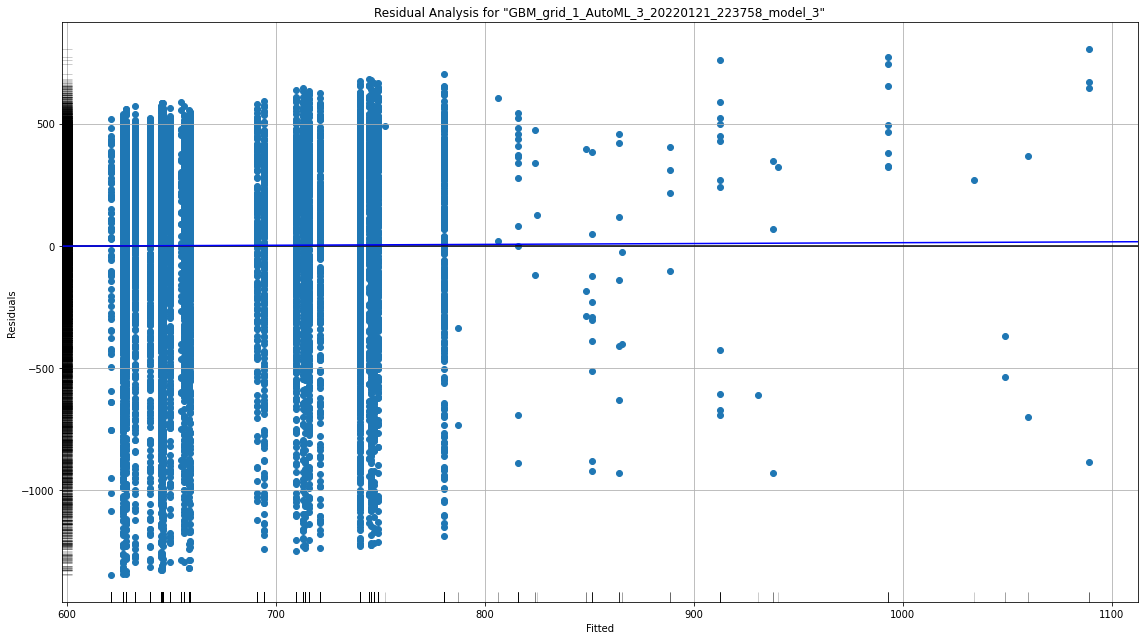

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

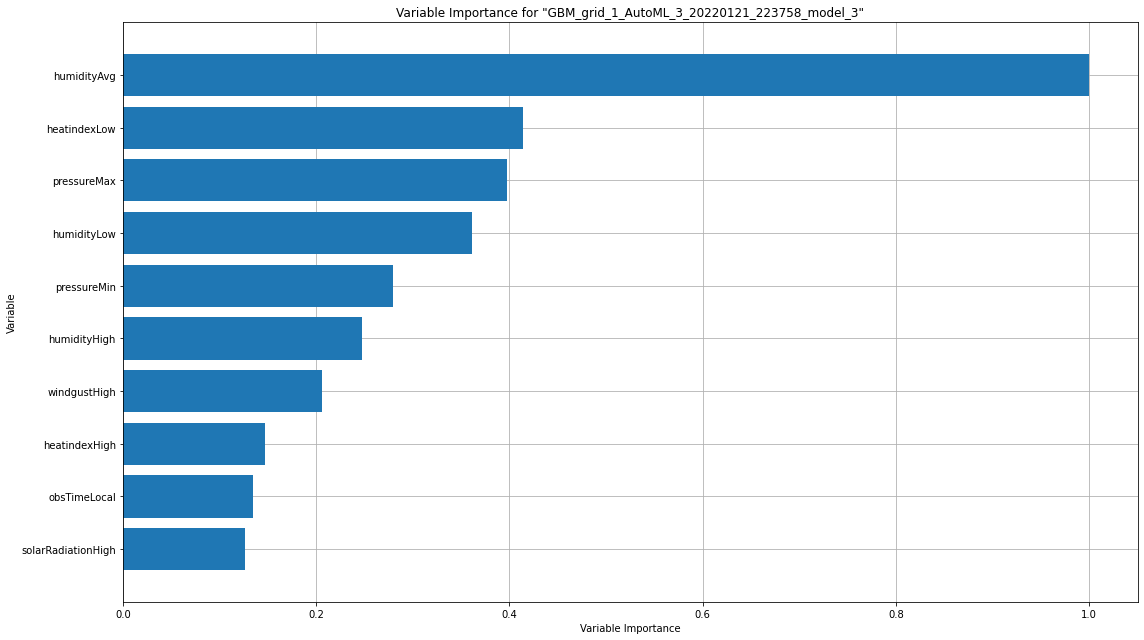

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

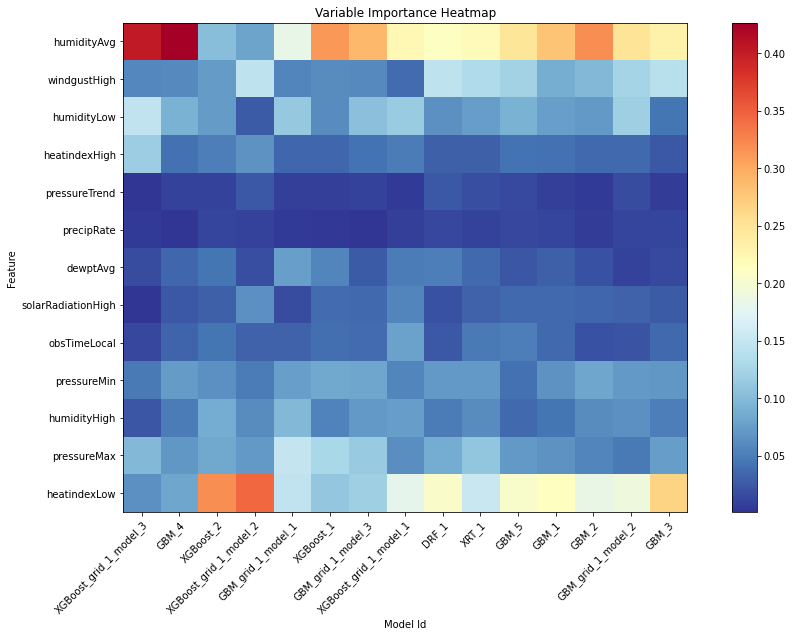

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

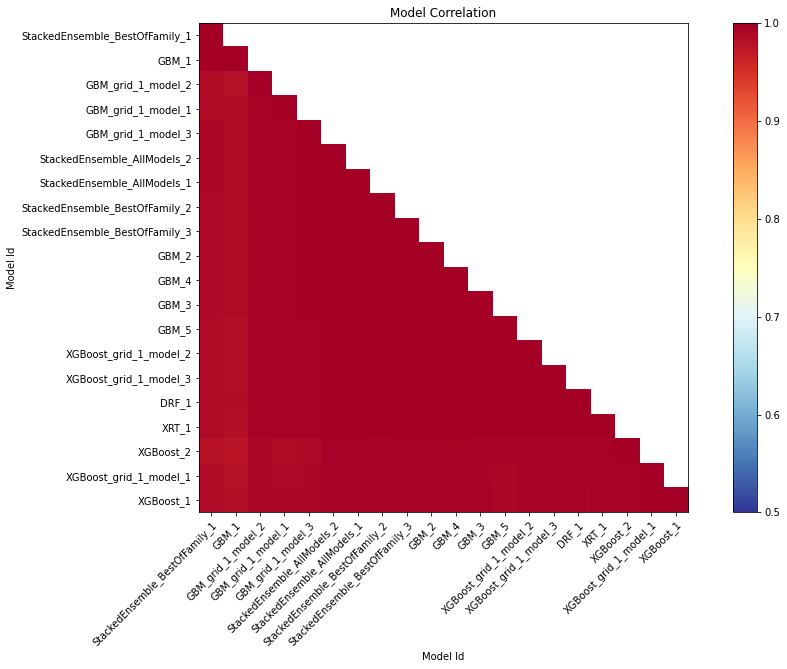

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

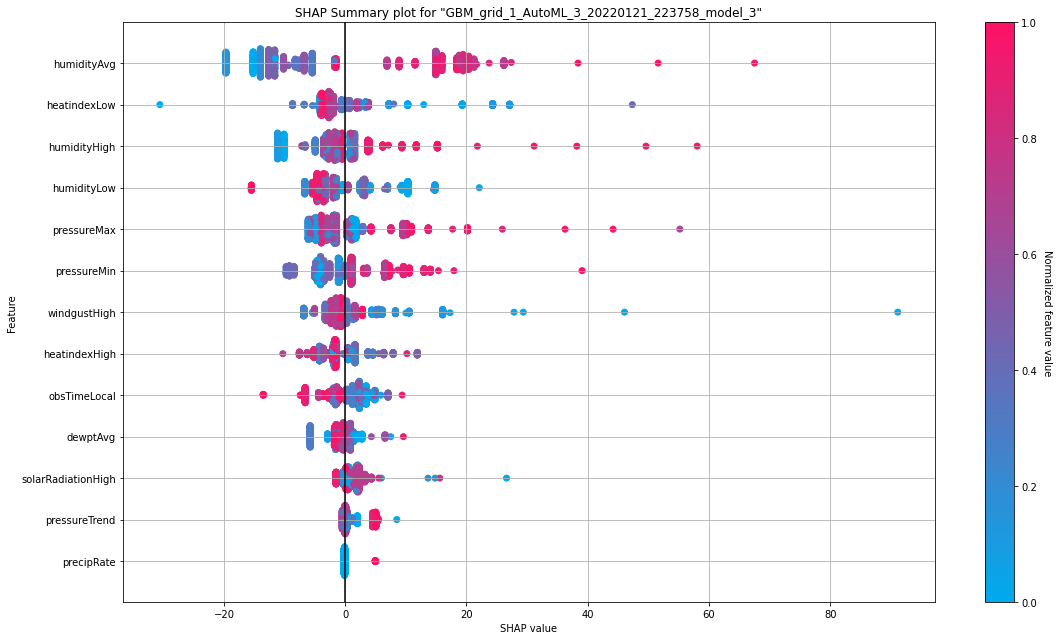

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

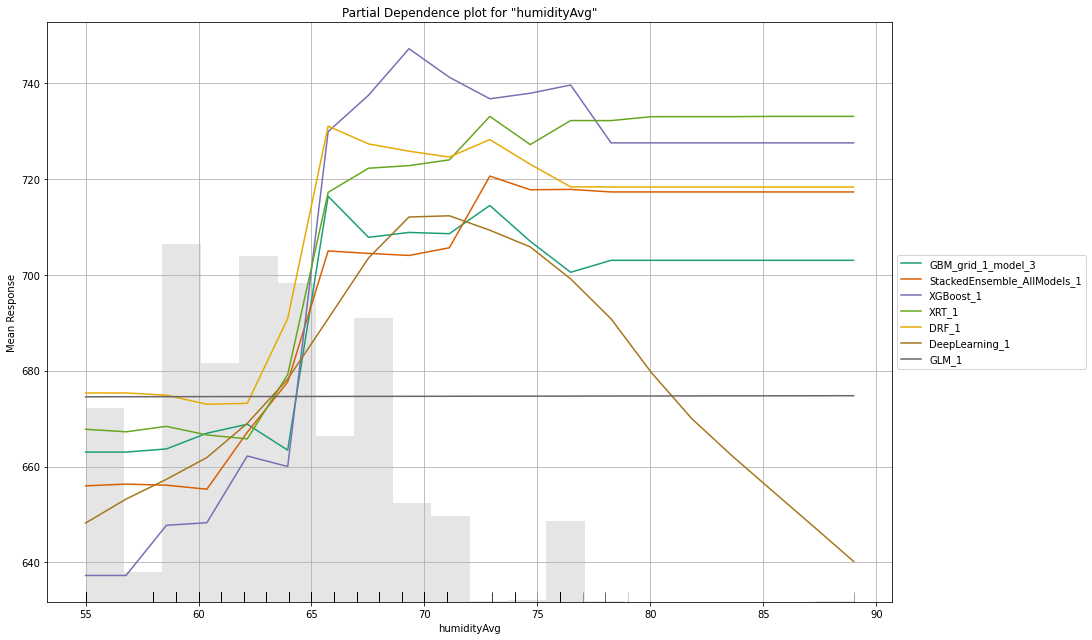

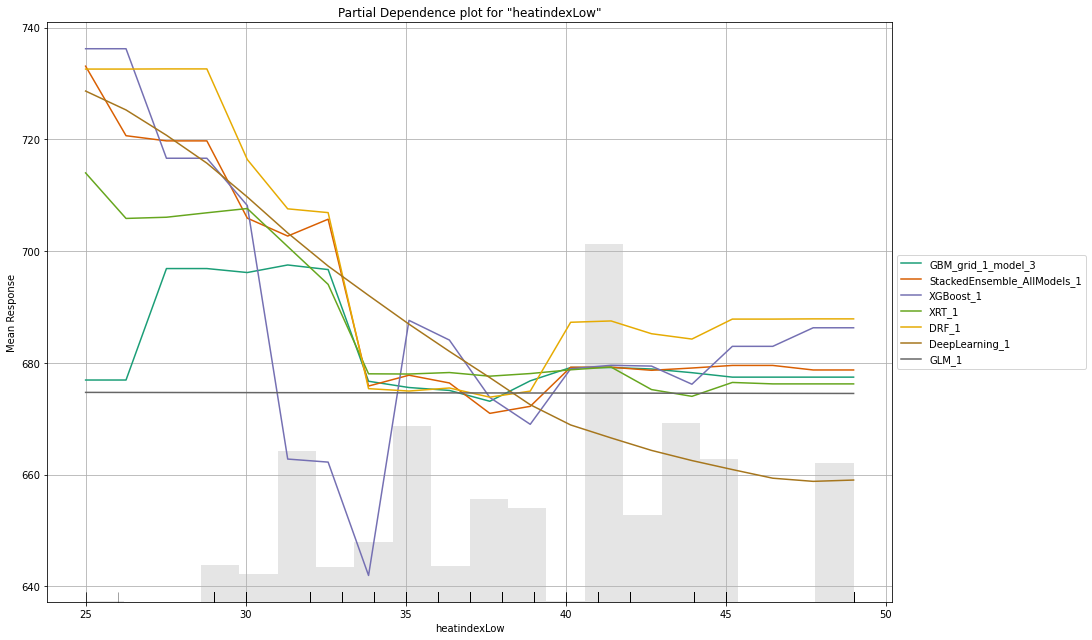

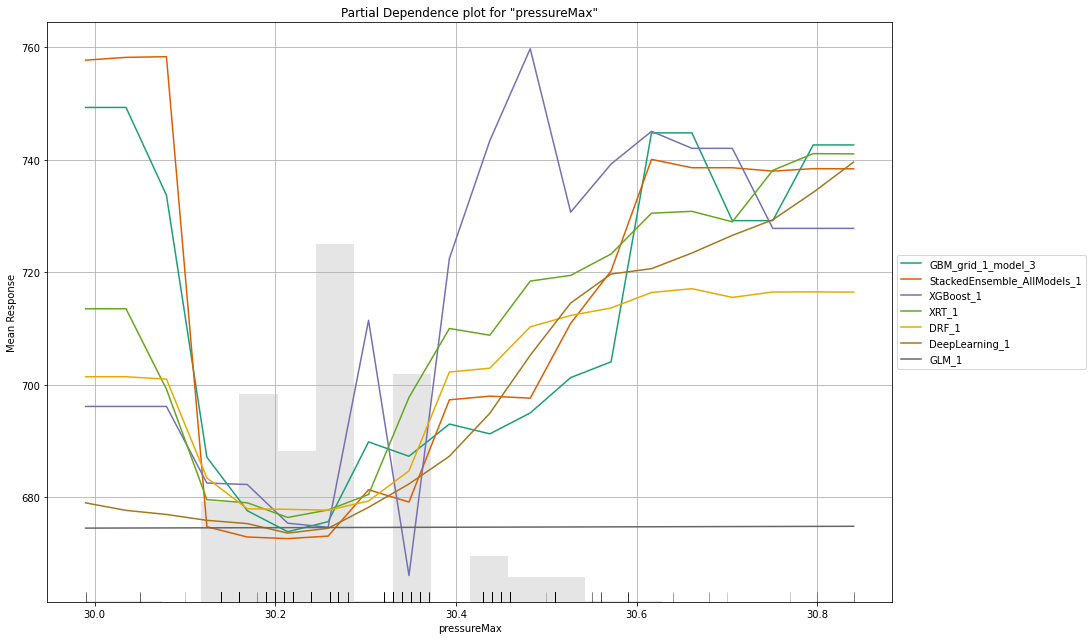

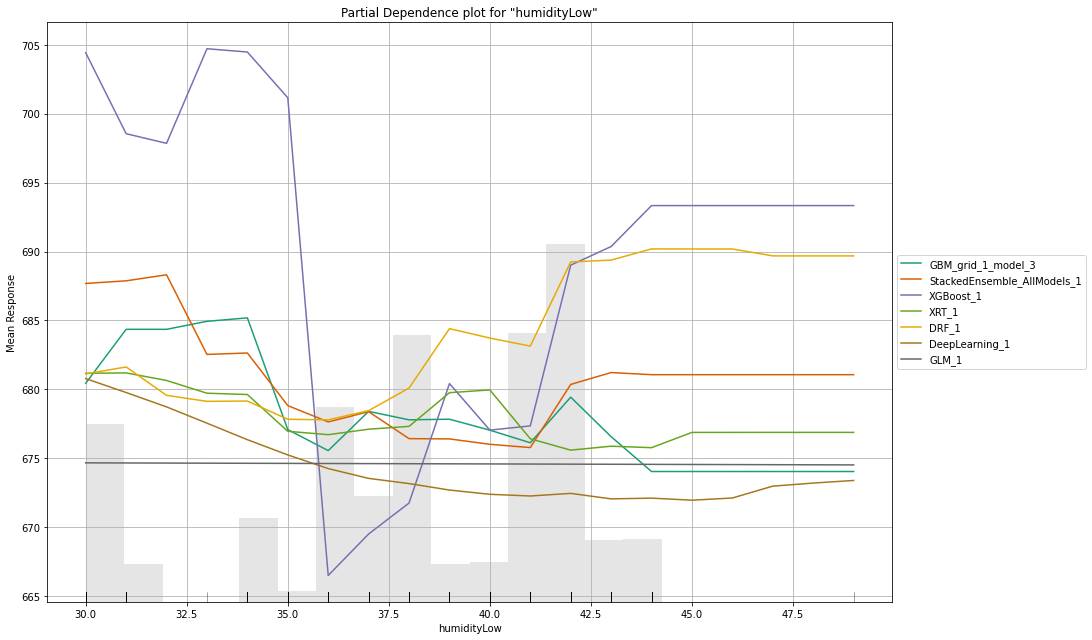

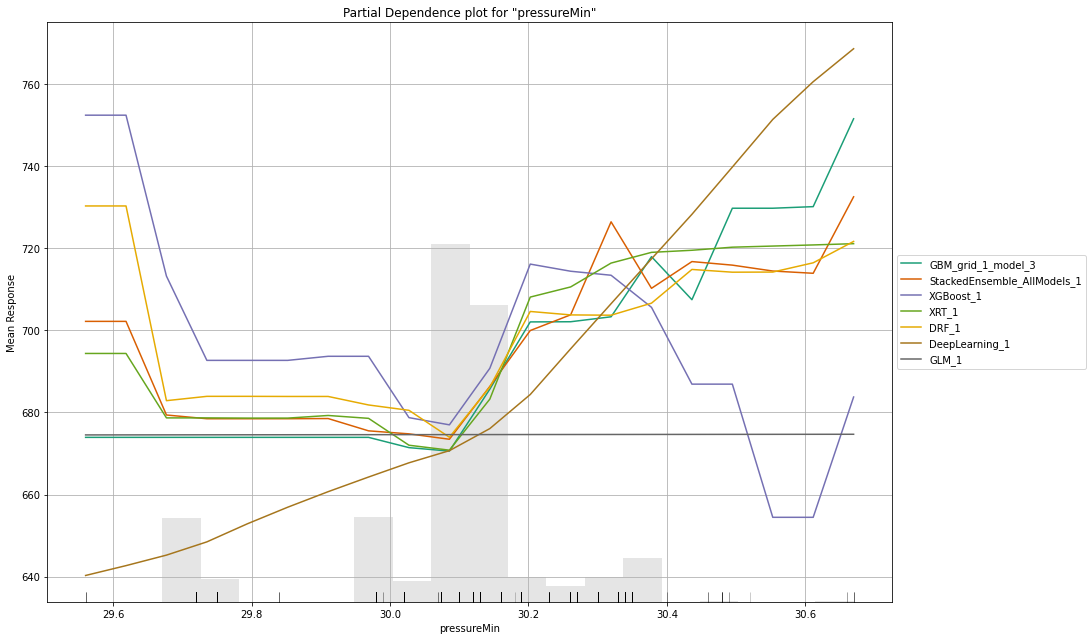

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

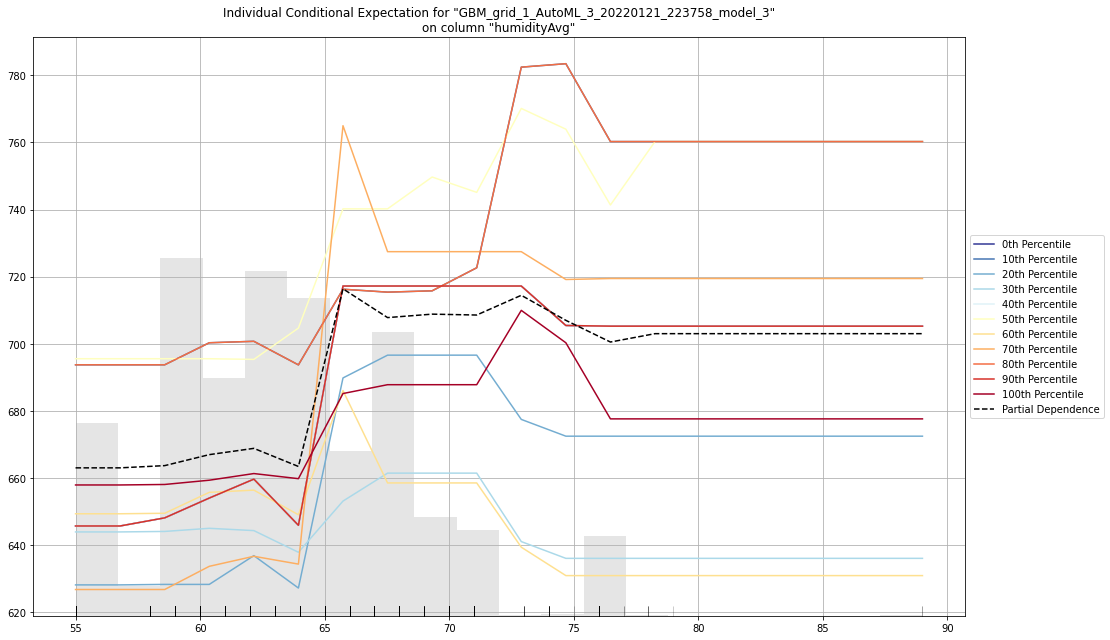

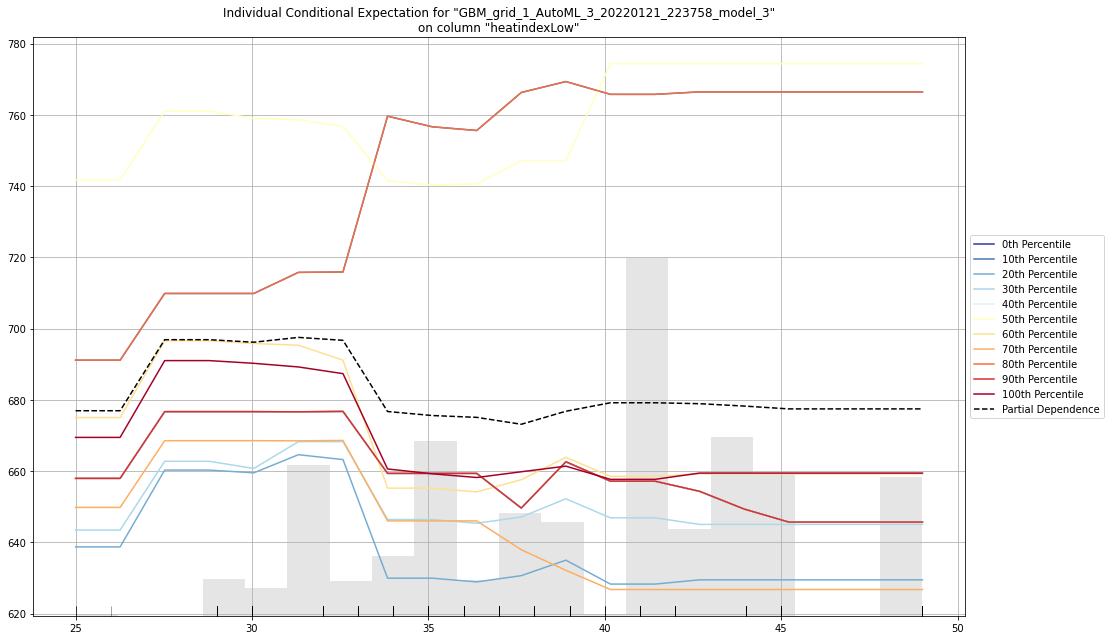

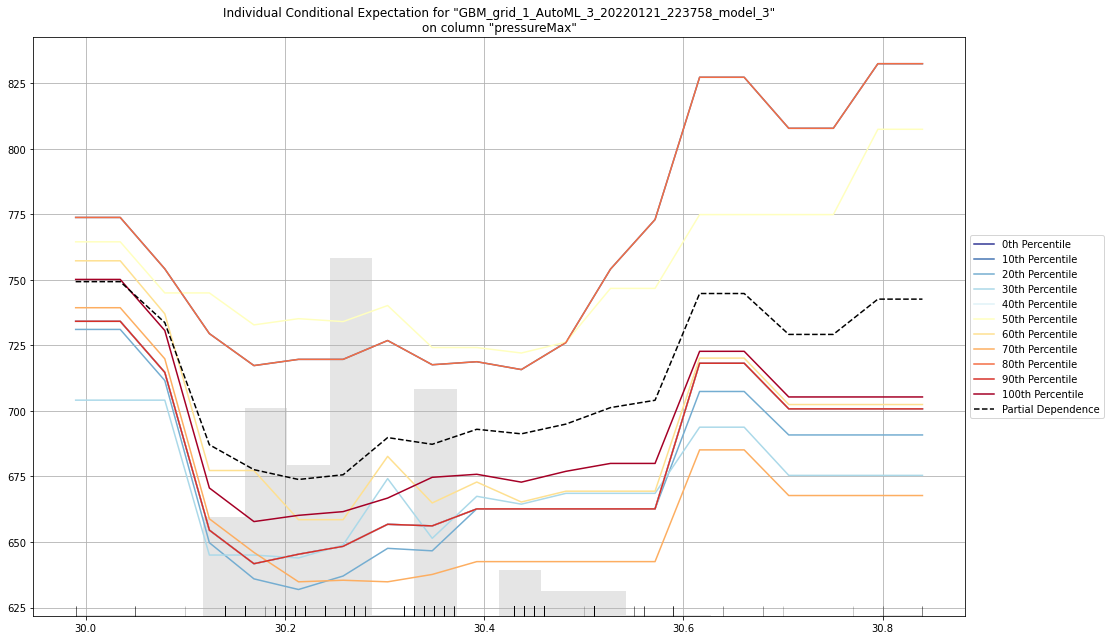

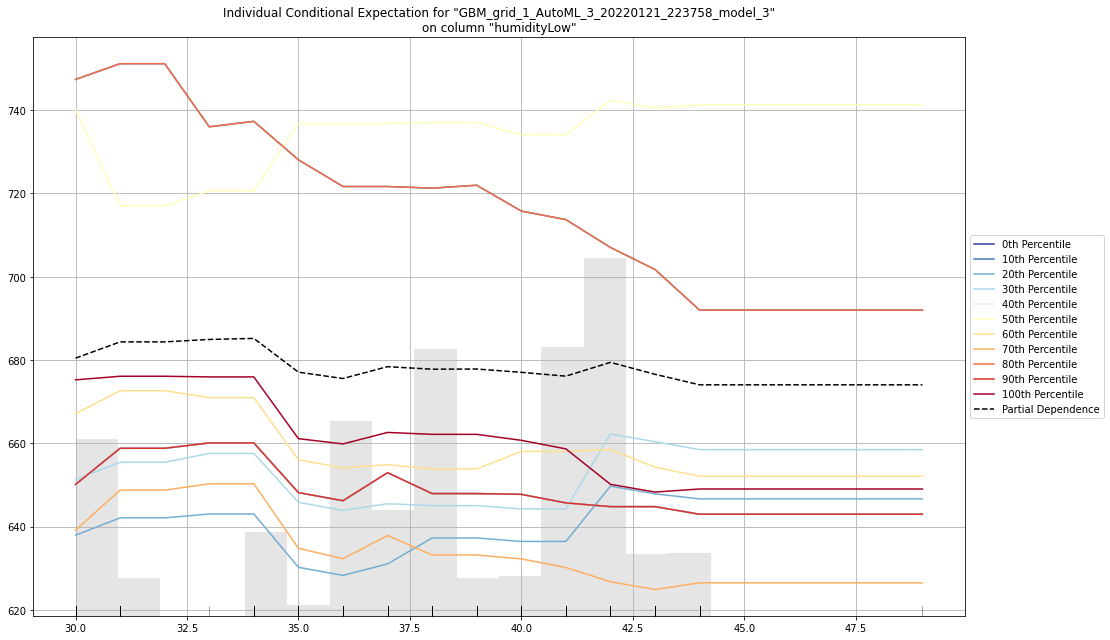

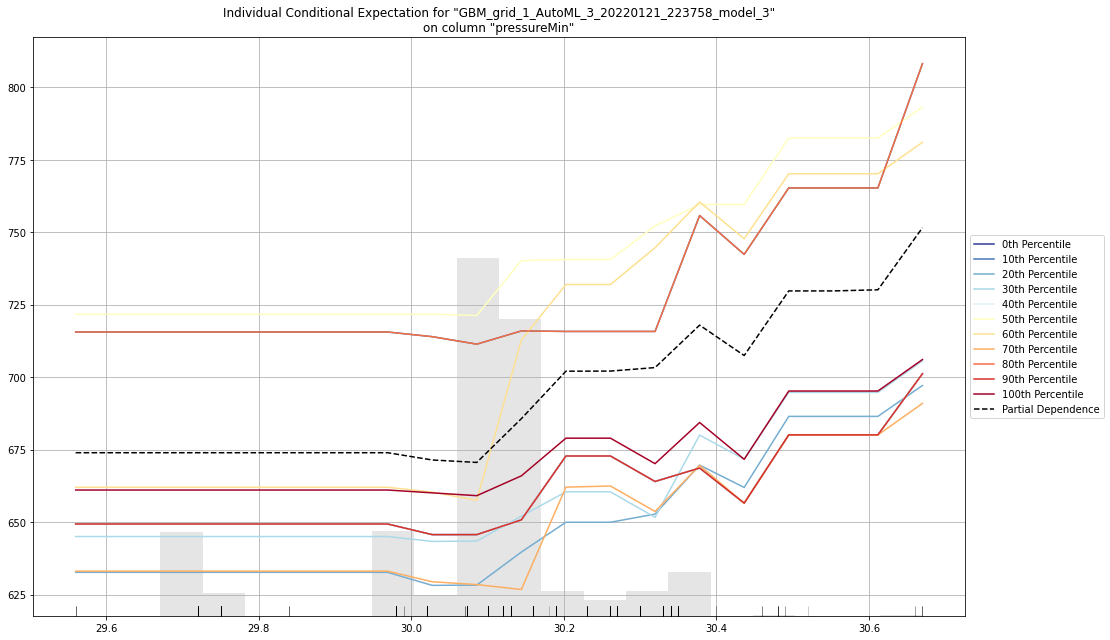

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo 
 
 
 GBM_grid_1_AutoML_3_20220121_223758_model_3 168563 410.564 168563 327.787 0.659194 948 0.005761 GBM 
 GBM_grid_1_AutoML_3_20220121_223758_model_1 168571 410.574 168571 327.873 0.659331 916 0.004473 GBM 
 GBM_2_AutoML_3_20220121_223758 168574 410.578 168574 327.842 0.659299 1180 0.004818 GBM 
 GBM_3_AutoML_3_20220121_223758 168575 410.579 168575 327.774 0.659175 1377 0.004794 GBM 
 GBM_4_AutoML_3_20220121_223758 168577 410.581 168577 327.826 0.659283 1410 0.004642 GBM 
 GBM_1_AutoML_3_20220121_223758 168580 410.585 168580 327.881 0.659374 1622 0.005528 GBM 
 StackedEnsemble_AllModels_1_AutoML_3_20220121_223758 168583 410.589 168583 327.898 0.659383 1019 0.021742 StackedEnsemble 
 StackedEnsemble_AllModels_2_AutoML_3_20220121_223758 168590 410.597 168590 327.898 0.659385 1004 0.023176 StackedEnsemble 
 StackedEnsemble_BestOfFamily_3_AutoML_3_20220121_223758 168591 410.599 168591 327.896 0.659391 650 0.008315 StackedEnsemble 
 GBM_grid_1_AutoML_3_20220121_223758_model_2 168593 410.6 168593 327.891 0.65939 1083 0.004489 GBM 
 StackedEnsemble_BestOfFamily_2_AutoML_3_20220121_223758 168599 410.608 168599 327.908 0.659411 641 0.006455 StackedEnsemble 
 StackedEnsemble_BestOfFamily_1_AutoML_3_20220121_223758 168607 410.618 168607 327.879 0.659377 678 0.007541 StackedEnsemble 
 XGBoost_1_AutoML_3_20220121_223758 168623 410.637 168623 327.812 0.659323 2191 0.001939 XGBoost 
 XGBoost_grid_1_AutoML_3_20220121_223758_model_3 168629 410.645 168629 327.519 0.658676 1098 0.000845 XGBoost 
 GBM_5_AutoML_3_20220121_223758 168629 410.645 168629 327.95 0.659523 1226 0.005066 GBM 
 XRT_1_AutoML_3_20220121_223758 168636 410.653 168636 327.727 0.659114 2138 0.006212 DRF 
 XGBoost_grid_1_AutoML_3_20220121_223758_model_2 168639 410.656 168639 327.692 0.659089 1881 0.001945 XGBoost 
 DRF_1_AutoML_3_20220121_223758 168656 410.678 168656 327.813 0.659297 1541 0.006598 DRF 
 XGBoost_grid_1_AutoML_3_20220121_223758_model_1 168670 410.695 168670 327.84 0.659381 1968 0.002007 XGBoost 
 XGBoost_2_AutoML_3_20220121_223758 168676 410.702 168676 327.815 0.659356 2653 0.001953 XGBoost

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [ ]:
aml3.explain(hf_test)

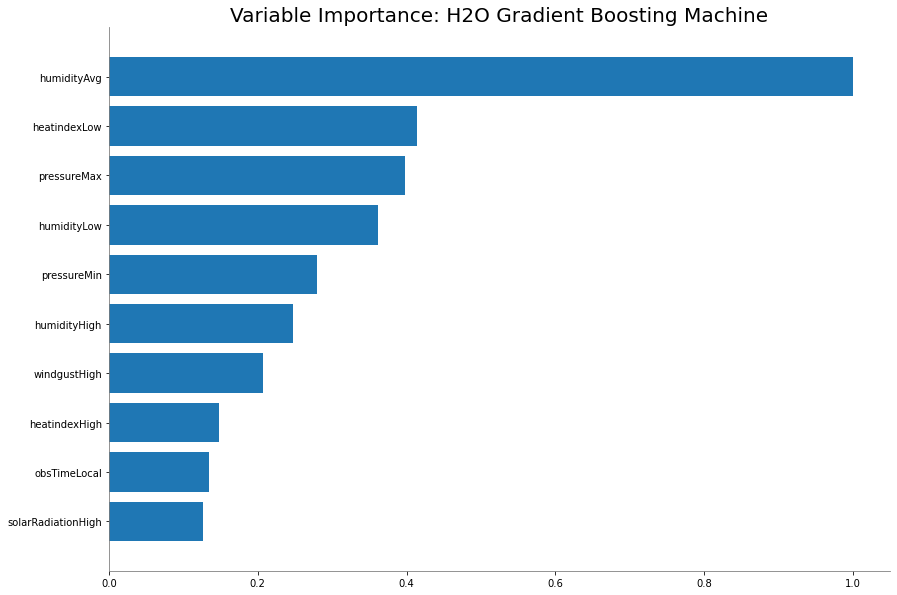

<Figure size 432x288 with 0 Axes>

In [ ]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_3_20220121_223758_model_3 on column 'humidityAvg'.


humidityavg  mean_response  stddev_response  std_error_mean_response
0     55.000000     662.993142        32.099069                 0.123756
1     56.789474     662.993142        32.099069                 0.123756
2     58.578947     663.655935        31.972615                 0.123268
3     60.368421     666.919103        31.840094                 0.122757
4     62.157895     668.792509        30.882312                 0.119065
5     63.947368     663.382977        33.422582                 0.128859
6     65.736842     716.155108        40.629395                 0.156644
7     67.526316     707.566322        37.337653                 0.143953
8     69.315789     708.578043        37.977165                 0.146418
9     71.105263     708.314459        37.574200                 0.144865
10    72.894737     713.951584        54.336779                 0.209492
11    74.684211     706.454125        55.834937                 0.215268
12    76.473684     700.071127        49.984920                 0.192714
13    78.263158     702.559785        52.940926                 0.204110
14    80.052632     702.559785        52.940926                 0.204110
15    81.842105     702.559785        52.940926                 0.204110
16    83.631579     702.559785        52.940926                 0.204110
17    85.421053     702.559785        52.940926                 0.204110
18    87.210526     702.559785        52.940926                 0.204110
19    89.000000     702.559785        52.940926                 0.204110

[]

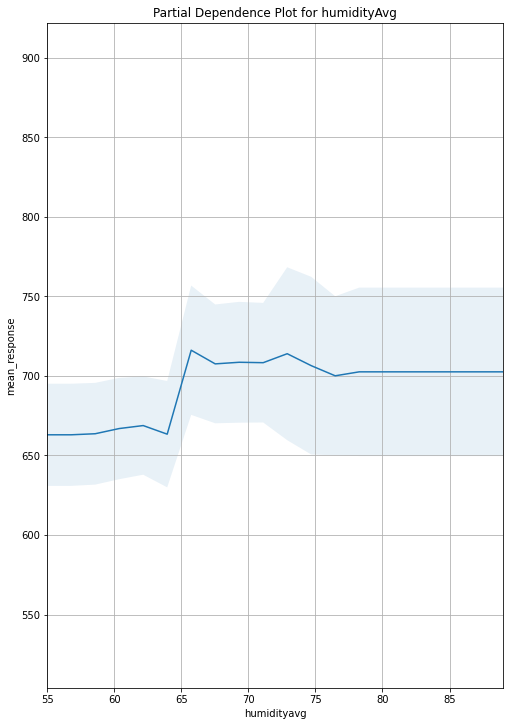

In [ ]:
best_model.partial_plot(hf, cols=['humidityAvg'])

In the partial dependence plots found above at aml3.explain() and here, we see that once average humidity goes above 65, we see increased trip duration.

# Conclusion

We found evidence to believe that **once average humdity goes above 65**, there will be increased trip durations for Blue Bike trips in the month of November in the city of Boston.